In [1]:
import numpy as np, pandas as pd, gym
from gym import spaces
import ta
from sklearn.base import TransformerMixin
import tensorflow as tf
from hmmlearn.hmm import GaussianHMM
from scipy.stats import norm
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.FileHandler("training.log"),
        logging.StreamHandler()
    ]
)

logger = logging.getLogger("DDQN")


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print("Gpu aktiviert")

# ---------- RollingWindowScaler ----------
class RollingWindowScaler(TransformerMixin):
    def __init__(self, window_size: int, cols: list, eps: float = 1e-8):
        self.window_size = window_size; self.cols = cols; self.eps = eps
    def fit(self, X, y=None): return self
    def transform(self, X: pd.DataFrame):
        arr = X[self.cols].values; n, f = arr.shape
        out = np.zeros_like(arr, dtype=np.float32)
        for i in range(n):
            s = max(0, i - self.window_size + 1)
            win = arr[s:i+1]; mean, std = win.mean(0), win.std(0) + self.eps
            out[i] = (arr[i] - mean) / std
        return out
    def fit_transform(self, X: pd.DataFrame, y=None): return self.transform(X)

# ---------- Helfer: Zonen + Kontext ----------
def _step_return(cur_price, next_price):
    return (next_price - cur_price) / (cur_price + 1e-9)

def _extract_zones(sig: np.ndarray):
    zones, in_zone, s, sign = [], False, 0, 0
    for i, v in enumerate(sig):
        if not in_zone and v != 0:
            in_zone, s, sign = True, i, v
        elif in_zone and v != sign:
            zones.append((s, i-1, sign)); in_zone = False
            if v != 0: in_zone, s, sign = True, i, v
    if in_zone: zones.append((s, len(sig)-1, sign))
    return zones

def _add_zone_context(df, pre_bars=8, head_len=24, min_fit=6, confirm=0):
    """
    Leak-frei & kausal:
      - pre_slope[t] wird nur aus Close[fit_start:t] berechnet (<= t)
      - zone_pos/zone_len wachsen kausal innerhalb der Zone
      - zone_head[t] = 1.0 nur in der Head-Phase (s..s+head_len-1)
    """
    n = len(df)
    close = df['Close'].to_numpy(dtype=float)
    # vol_signal sollte vorher bereits erzeugt sein
    sig = df['vol_signal'].to_numpy(dtype=float)

    pre_slope = np.full(n, np.nan, dtype=np.float32)
    zone_pos  = np.zeros(n, dtype=np.float32)
    zone_len  = np.zeros(n, dtype=np.float32)
    zone_head = np.zeros(n, dtype=np.float32)

    zones = _extract_zones(sig)  # [(s, e, sign), ...]
    for s, e, _ in zones:
        fit_start = max(0, s - pre_bars)
        head_end  = min(e, s + head_len - 1)

        # Head-Phase kausal: für jedes t nur Daten <= t verwenden
        for t in range(max(s + confirm, s), head_end + 1):
            y = close[fit_start : t + 1]
            if len(y) < min_fit or not np.isfinite(y).all():
                continue
            L = len(y)
            x = np.arange(L, dtype=np.float64)
            xz = x - x.mean()
            yz = y - y.mean()
            denom = (xz * xz).sum() + 1e-12
            m = float((xz * yz).sum() / denom)
            slope_norm = m / (y[0] + 1e-9)

            pre_slope[t] = slope_norm
            zone_head[t]  = 1.0

        # Zonenmetadaten kausal (keine Zukunftsinfo über e bei t)
        for t in range(s, e + 1):
            L_t = t - s + 1
            zone_len[t] = float(L_t)
            zone_pos[t] = (t - s) / max(1.0, L_t)

    # Jetzt erst in den DataFrame schreiben (spalten existieren ab hier)
    df['pre_slope'] = pd.Series(pre_slope, index=df.index, dtype=np.float32)
    df['zone_pos']  = pd.Series(zone_pos,  index=df.index, dtype=np.float32)
    df['zone_len']  = pd.Series(zone_len,  index=df.index, dtype=np.float32)
    df['zone_head'] = pd.Series(zone_head, index=df.index, dtype=np.float32)
    return df

def predictive_signal_live_block(model, block_returns, tau=0.0):
    """
    Leak-frei. Gibt zurück:
      sig (binär vs tau), rhat, zhat, alpha_t=p(z_t|1:t), pnext_t=p(z_{t+1}|1:t)
    """
    rets = block_returns.values
    n = len(rets); K = model.n_components
    pi, A = model.startprob_, model.transmat_
    mu = model.means_unscaled_.ravel()
    var = model.covars_unscaled_.ravel()

    # Init
    b0 = np.array([gaussian_pdf(rets[0], mu[k], var[k]) for k in range(K)])
    alpha = pi * b0; alpha = alpha/alpha.sum() if alpha.sum()>0 else np.ones(K)/K

    sig = np.zeros(n); rhat = np.zeros(n); zhat = np.zeros(n)
    alphas = np.zeros((n, K)); pnext = np.zeros((n, K))
    alphas[0] = alpha

    # t=0 -> Vorhersage für 1
    pred = alpha @ A; pnext[0] = pred
    rhat[0] = (pred * mu).sum()
    er2 = (pred * (var + mu**2)).sum()
    var_next = max(er2 - rhat[0]**2, 1e-12)
    zhat[0] = rhat[0] / np.sqrt(var_next)
    sig[0] = 1.0 if zhat[0] > tau else 0.0

    for t in range(1, n):
        bt = np.array([gaussian_pdf(rets[t], mu[k], var[k]) for k in range(K)])
        pred_t = alpha @ A
        at = pred_t * bt; s = at.sum()
        alpha = (at / s) if np.isfinite(s) and s>0 else np.ones(K)/K
        alphas[t] = alpha

        pred = alpha @ A; pnext[t] = pred
        rhat[t] = (pred * mu).sum()
        er2 = (pred * (var + mu**2)).sum()
        var_next = max(er2 - rhat[t]**2, 1e-12)
        zhat[t] = rhat[t] / np.sqrt(var_next)
        sig[t] = 1.0 if zhat[t] > tau else 0.0

    idx = block_returns.index
    return (pd.Series(sig, index=idx),
            pd.Series(rhat, index=idx),
            pd.Series(zhat, index=idx),
            pd.DataFrame(alphas, index=idx, columns=[f"st{k}" for k in range(K)]),
            pd.DataFrame(pnext,  index=idx, columns=[f"st{k}" for k in range(K)]))


def gaussian_pdf(x, mean, var):
    var = max(float(var), 1e-12)
    std = np.sqrt(var)
    return norm.pdf(x, loc=mean, scale=std) + 1e-300

#####################################################################

def ewma_vol(x, span=48):
    r = pd.Series(x, dtype=float)
    vol = r.ewm(span=span, adjust=False).std()
    # kausal: am Anfang NA lassen oder vorwärts füllen – aber niemals bfill
    return vol.ffill()  # oder .fillna(vol.iloc[~vol.isna()].min())


#def ewma_vol(x, span=48):
    #r = pd.Series(x).astype(float)
    # annualisiert nicht nötig – wir arbeiten pro Bar
    #return r.ewm(span=span, adjust=False).std().bfill()

#####################################################################

def state_roles_by_mean(model):
    """liefert (bull, neutral, bear) Indizes nach μ (unskaliert)"""
    order = np.argsort(model.means_unscaled_.ravel())  # klein -> groß
    bear = int(order[0]); neutral = int(order[1]); bull = int(order[2])
    return bull, neutral, bear

def fit_hmm_gaussian_stable(returns, n_states=2, random_state=1, n_iter=500, zscore=True, sticky=0.97):
    X_raw = returns.values.reshape(-1, 1)

    # ---- z-Score robust ----
    mu = float(np.nanmean(X_raw)) if X_raw.size else 0.0
    sd = float(np.nanstd(X_raw))  if X_raw.size else 1.0
    if not np.isfinite(sd) or sd <= 1e-12:
        sd = 1.0
    X = ((X_raw - mu) / sd).astype(float) if zscore else X_raw.astype(float)

    model = GaussianHMM(
        n_components=n_states, covariance_type="diag",
        n_iter=n_iter, tol=1e-4, random_state=random_state,
        init_params="", params="stmc", verbose=False,
    )
    model.n_features = 1

    rng = np.random.RandomState(random_state)

    # ---------- Initialisierung ----------
    if n_states == 3:
        # Fallback, wenn History zu kurz/leer ist
        if len(X) < 20 or not np.isfinite(X).all():
            means_init  = np.array([[-0.8],[0.0],[+0.8]])   # auf z-Scale
            covars_init = np.array([[1.0],[1.5],[1.0]])
        else:
            # datengetriebene Init
            from sklearn.cluster import KMeans
            km = KMeans(n_clusters=3, random_state=random_state, n_init=10)
            labels = km.fit_predict(X)                      # <- hier war der Crash
            means_km = np.array([X[labels==k].mean() if np.any(labels==k) else 0.0 for k in range(3)])
            vars_km  = np.array([X[labels==k].var()  if np.any(labels==k) else X.var() for k in range(3)])
            order = np.argsort(means_km)
            means_init = means_km[order].reshape(3,1)
            vars_init  = vars_km[order].reshape(3,1)
            covars_init = np.array([
                [max(vars_init[0,0], 0.6)],   # bear
                [max(vars_init[1,0], 1.2)],   # neutral (breiter)
                [max(vars_init[2,0], 0.6)],   # bull
            ])

        model.means_  = means_init
        model.covars_ = covars_init

        stay_bear, stay_neu, stay_bull = 0.95, 0.90, 0.95
        A = np.array([
            [stay_bear, (1-stay_bear)*0.6, (1-stay_bear)*0.4],
            [(1-stay_neu)*0.5,  stay_neu,  (1-stay_neu)*0.5],
            [(1-stay_bull)*0.4, (1-stay_bull)*0.6, stay_bull]
        ])
        model.transmat_  = A / A.sum(axis=1, keepdims=True)
        model.startprob_ = np.array([0.34, 0.32, 0.34])

    else:
        sp = rng.rand(n_states); sp /= sp.sum()
        model.startprob_ = sp
        A = np.full((n_states, n_states), (1.0 - sticky) / (n_states - 1))
        np.fill_diagonal(A, sticky)
        model.transmat_ = A
        gvar = float(np.nanvar(X)) if np.isfinite(np.nanvar(X)) and np.nanvar(X)>1e-12 else 1.0
        model.means_  = np.zeros((n_states,1))
        model.covars_ = np.full((n_states,1), 1.0 if zscore else gvar)

    # ---------- Fit ----------
    if len(X) == 0:
        raise ValueError("HMM fit: leere History übergeben.")
    model.fit(X)

    # Var-Floors sichern (3 States)
    if n_states == 3:
        order = np.argsort(model.means_.ravel()); neutral_idx = int(order[1])
        cov = np.asarray(model.covars_, dtype=float).reshape(model.n_components, model.n_features)
        cov[neutral_idx, 0] = max(cov[neutral_idx, 0], 1.0)
        cov = np.maximum(cov, 0.3)
        model.covars_ = cov

    # Unscale persistieren
    model._zscore = zscore; model._mu, model._sd = mu, sd
    if zscore:
        model.means_unscaled_  = model.means_ * sd + mu
        model.covars_unscaled_ = model.covars_ * (sd ** 2)
    else:
        model.means_unscaled_  = model.means_.copy()
        model.covars_unscaled_ = model.covars_.copy()
    return model

def walk_forward_live(test_df, seed_df, retrain_every_h=24*2, lookback_h=24*25,
                      zscore=True, sticky=0.95, exec_shift=True,
                      side="short",    # "long" | "short"
                      gamma=0.50, alpha=0.50,
                      vol_span=36, target=0.0018):

    ts = test_df.reset_index(drop=True)
    sig = np.zeros(len(ts))
    hist = seed_df.copy()
    i = 0
    while i < len(ts):
        # Refit auf letzter History (lookback)
        hist_cut = hist.iloc[-lookback_h:] if lookback_h else hist
        mdl = fit_hmm_gaussian_stable(hist_cut["ret"], n_states=3, random_state=1,
                                      n_iter=400, zscore=zscore, sticky=sticky)

        j = min(i + retrain_every_h, len(ts))
        block = ts.iloc[i:j]

        # >>> prädiktives, leak-freies Signal (z-Score-basierte Schwelle)
        # prädiktives Signal berechnen
        # >>> prädiktives, leak-freies Signal
        # prädiktiv + Wahrscheinlichkeiten
        # --- prädiktiv + Wahrscheinlichkeiten (3-State) ---
        _, rhat_blk, zhat_blk, alpha_blk, pnext_blk = predictive_signal_live_block(mdl, block["ret"], tau=0.00)
        bull, neutral, bear = state_roles_by_mean(mdl)  # (μ sortiert)

        # --- Temperatur-Schärfung ---
        P = np.power(pnext_blk.values + 1e-12, gamma)
        P = P / P.sum(axis=1, keepdims=True)
        
        bull, neutral, bear = state_roles_by_mean(mdl)
        P_b, P_n, P_r = P[:, bull], P[:, neutral], P[:, bear]
        P_nb = np.maximum(P_b + P_r, 1e-9)
        
        if side == "long":
            # Long-Edge: Bull minus Bear (konditioniert auf nicht-neutral)
            edge = (P_b - P_r) / P_nb
        elif side == "short":
            # Short-Edge: Bear minus Bull (konditioniert auf nicht-neutral)
            edge = (P_r - P_b) / P_nb
        else:
            raise ValueError("side must be 'long' or 'short'")
        
        # weiches Neutral-Gate
        edge = np.clip(edge, 0.0, 1.0) * (1.0 - P_n) ** alpha  # 0..1
        
        # Volatility-Targeting
        vol_blk = ewma_vol(block["ret"].values, span=vol_span); vol_blk.index = block.index
        scale   = np.clip(target / (vol_blk.values + 1e-12), 0.5, 3.0)
        w = np.clip(edge * scale, 0.0, 1.0)
        
        # leichte Glättung
        w = pd.Series(w, index=block.index).ewm(span=3, adjust=False).mean().clip(0.0, 1.0)
        
        # Debug (optional)
        if (j - i) >= 24:
            wr = pd.Series(edge, index=block.index)
            #print(f"[WF {i}:{j}] side={side} edge p50/p80={wr.quantile(0.5):.2f}/{wr.quantile(0.8):.2f} "
                  #f"Pneu med={np.median(P_n):.2f} mean w={w.mean():.2f}")
        
        # reinschreiben
        sig[i:j] = w.values


        # optional: Diagnose
        # print(f"[{i}:{j}] long_ratio={sig_blk.mean():.2f}  ẑ∈[{zhat_blk.min():.2f},{zhat_blk.max():.2f}]")

        # History um gesehenen Block erweitern
        hist = pd.concat([hist, block[["timestamp","Close","ret"]]], axis=0)
        i = j

    sig = pd.Series(sig, index=test_df.index)
    if exec_shift:
        sig = sig.shift(1).fillna(0.0)
    
    # Return-Vorzeichen je nach Richtung
    ret = test_df["ret"]
    strat = ret * sig if side == "long" else (-ret * sig)
    
    return sig, strat


# ---------- Feature Engineering ----------
def add_indicators(df):
    df = df.copy()
    # Basics
    #df['Volatility'] = df['Close'].pct_change().rolling(10).std()  #Feature kaum benutzt
    #df['Momentum']   = df['Close'].pct_change(10)  #Feature kaum benutzt
    df['Momentum_3'] = df['Close'].pct_change(3)
    df['OBV']        = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    df['Returns']    = df['Close'].pct_change()

    # RSI
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = -delta.where(delta < 0, 0).rolling(14).mean()
    rs = gain / (loss + 1e-10); df['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    df['MACD']        = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Bollinger
    sma20 = df['Close'].rolling(20).mean()
    std20 = df['Close'].rolling(20).std()
    df['Bollinger_Upper'] = sma20 + 2 * std20
    df['Bollinger_Lower'] = sma20 - 2 * std20

    # ATR / norm_range / Hawkes-Vol
    # ATR (schon kausal, weil rolling default center=False ist)
    df['ATR'] = ta.volatility.average_true_range(
        high=df['High'], low=df['Low'], close=df['Close'], window=96
    )
    
    # Variante A (kausal, inkl. aktuellem Wert im Fenster) – ok:
    ma = df['ATR'].rolling(64, min_periods=8).mean()
    sd = df['ATR'].rolling(64, min_periods=8).std()
    
    # Variante B (strikt „nur Vergangenheit“ – noch konservativer):
    ma_past = df['ATR'].shift(1).rolling(64, min_periods=8).mean()
    sd_past = df['ATR'].shift(1).rolling(64, min_periods=8).std()
    
    df['ATR_z'] = (df['ATR'] - (ma_past if True else ma)) / ((sd_past if True else sd) + 1e-8)

    df['norm_range'] = (np.log(df['High']) - np.log(df['Low'])) / (df['ATR'] + 1e-10)
    

    def hawkes_process(series, kappa=0.1):
        alpha = np.exp(-kappa); out = np.full(len(series), np.nan); arr = series.to_numpy()
        for i in range(1, len(series)):
            out[i] = arr[i] if np.isnan(out[i-1]) else out[i-1]*alpha + arr[i]
        return pd.Series(out, index=series.index) * kappa
    df['v_hawk'] = hawkes_process(df['norm_range'], kappa=0.1)

    def vol_signal(close, vol_hawk, lookback=96):
        signal = np.zeros(len(close))
        q05 = vol_hawk.rolling(lookback).quantile(0.02)
        q95 = vol_hawk.rolling(lookback).quantile(0.98)
        last_below = -1
        curr = 0.0
        for i in range(len(signal)):
            if np.isnan(q05.iloc[i]) or np.isnan(q95.iloc[i]) or i == 0:
                signal[i] = curr
                continue
    
            if vol_hawk.iloc[i] < q05.iloc[i]:
                last_below, curr = i, 0.0
    
            crossed_up = (vol_hawk.iloc[i] > q95.iloc[i]) and (vol_hawk.iloc[i-1] <= q95.iloc[i-1])
            if crossed_up and last_below >= 0:
                curr = 1.0 if (close.iloc[i] - close.iloc[last_below]) > 0 else -1.0
    
            signal[i] = curr
        return pd.Series(signal, index=close.index)
    df['vol_signal'] = vol_signal(df['Close'], df['v_hawk'], lookback=96)
    #print(df)



    def add_hmm_signals(df: pd.DataFrame, retrain_every=24*2, lookback=24*30) -> pd.DataFrame:
        df = df.copy()
        df["ret"] = np.log(df["Close"]).diff()
        df["ret"] = np.log(df["Close"]).diff().fillna(0.0)
    
        # Dummy-Timestamp, falls nicht vorhanden
        if "timestamp" not in df.columns:
            df["timestamp"] = df.index
            df["timestamp"] = pd.to_numeric(df["timestamp"], errors='coerce')

    
        # Dummy-Seed (erstes Drittel für Seed-Modell)
        seed_len = int(0.33 * len(df))
        seed_df = df.iloc[:seed_len].copy()
        test_df = df.iloc[seed_len:].copy()
    
        for side in ["long", "short"]:
            hmm_signal, _ = walk_forward_live(
                test_df=test_df.copy(),
                seed_df=seed_df.copy(),
                retrain_every_h=retrain_every,
                lookback_h=lookback,
                zscore=True,
                sticky=0.95,
                exec_shift=True,
                side=side,
                gamma=0.50, alpha=0.50,
                vol_span=24, target=0.0015 if side == "long" else 0.0012
            )
            # Fill initial NaNs mit 0
            sig_full = pd.Series(0.0, index=df.index)
            sig_full.iloc[seed_len:] = hmm_signal.values
            df[f"hmm_{side}"] = sig_full.values
    
        return df
        
        
    df = add_hmm_signals(df)
    df['hmm_long'] = df['hmm_long'].fillna(0.0)
    df['hmm_short'] = df['hmm_short'].fillna(0.0)


    # Candle/Spreads
    df['Candle_Body'] = (df['Close'] - df['Open']).abs()
    df['HL_Spread']   = df['High'] - df['Low']
    df['Z_Close']     = (df['Close'] - sma20) / (std20 + 1e-10)

    # Zone-Kontext hinzufügen (vol_signal muss schon existieren)
    df = _add_zone_context(df, pre_bars=8, head_len=24, min_fit=6)
    df['pre_slope_mask'] = (~df['pre_slope'].isna()).astype(np.float32)
    df['pre_slope'] = df['pre_slope'].fillna(0.0)
    
    # NaNs auf den final genutzten Feature-Spalten entfernen
    scale_cols_local = [
        'Open','High','Low','Close','Volume','Turnover',
        'Momentum_3','OBV','Returns','RSI','hmm_long','hmm_short',
        'MACD','MACD_Signal','Bollinger_Upper','Bollinger_Lower',
        'Candle_Body','HL_Spread','Z_Close','ATR','norm_range','v_hawk'
    ]
    df.dropna(subset=scale_cols_local, inplace=True)


    #print(f"✅ Features: {list(df.columns)}")
    #print(f"❌ NaNs je Spalte:\n{df.isna().sum()}"); print(df.tail(5))
    return df

import numpy as np
from typing import List, Tuple

def generate_episode_indices(data_len: int,
                             episode_len: int = 400,
                             stride: int | None = None,
                             shuffle: bool = True) -> List[Tuple[int, int]]:
    """
    Erzeugt (start, end)-Paare für Episoden über einen Datenstream.
    - episode_len: Länge der Episode in Schritten (end ist exklusiv)
    - stride: Schrittweite zwischen Startpunkten; default = episode_len (keine Überlappung)
    - shuffle: ob die Episodenreihenfolge vor Training gemischt wird
    """
    if data_len <= episode_len + 1:
        # Falls zu wenig Daten: eine einzige Episode über (fast) alles
        return [(0, max(1, data_len - 1))]

    if stride is None:
        stride = episode_len

    indices = []
    # end ist exklusiv; wir brauchen mindestens einen Schritt Lookahead -> "-1"
    last_start = data_len - episode_len - 1
    for start in range(0, max(0, last_start + 1), stride):
        indices.append((start, start + episode_len))

    if not indices:
        indices = [(0, data_len - 1)]

    if shuffle:
        np.random.shuffle(indices)

    return indices

# ---------- Environment ----------
class BitgetTradingEnv(gym.Env):
    def __init__(self,
                 csv_path: str | None = None,
                 df: pd.DataFrame | None = None,
                 initial_balance=1700,
                 leverage=10.0,            # <- 10x
                 alloc=0.6,                # <- 100% des Eigenkapitals je Trade
                 fee_rate=0.0005,          # pro Seite (taker)
                 maint_margin=0.005,
                 max_hold=48, #24 war bisher am besten 
                 trail_pct=0.50):
        super().__init__()
        self.initial_balance = initial_balance
        self.leverage = float(leverage)
        self.alloc = float(alloc)
        self.fee_rate = float(fee_rate)
        self.maint_margin = float(maint_margin)
        self.max_hold = int(max_hold)
        self.trail_pct = float(trail_pct)

        # --- Daten laden ---
        if (csv_path is None) and (df is None):
            raise TypeError("BitgetTradingEnv: bitte entweder csv_path oder df übergeben.")
        
        if df is not None:
            raw = df.copy()
        else:
            raw = pd.read_csv(csv_path, parse_dates=['timestamp'])
        
        # Timestamp normalisieren (Spalte oder Index)
        if 'timestamp' in raw.columns:
            raw['timestamp'] = pd.to_datetime(raw['timestamp'], utc=True, errors='coerce')
            raw = raw.dropna(subset=['timestamp']).sort_values('timestamp').set_index('timestamp')
        else:
            # falls der Index schon ein DatetimeIndex ist
            if isinstance(raw.index, pd.DatetimeIndex):
                raw = raw.sort_index()
                if raw.index.tz is None:
                    raw.index = raw.index.tz_localize('UTC')
                else:
                    raw.index = raw.index.tz_convert('UTC')
            else:
                raise ValueError("Kein 'timestamp' und kein DatetimeIndex vorhanden.")
        
        # --- Spalten-Normalisierung (OHLCV + Turnover vereinheitlichen) ---
        # Map beliebter Varianten auf Standard
        col_map = {
            'open': 'Open', 'o': 'Open',
            'high': 'High', 'h': 'High',
            'low':  'Low',  'l': 'Low',
            'close':'Close','c': 'Close',
            'volume':'Volume','vol':'Volume','v':'Volume',
            'turnover':'Turnover','quote_volume':'Turnover','value':'Turnover'
        }
        # vorhandene Spalten auf lower -> map -> Capitalize
        new_cols = {}
        for c in raw.columns:
            key = str(c).strip().lower()
            new_cols[c] = col_map.get(key, c)  # map wenn bekannt, sonst unverändert
        raw = raw.rename(columns=new_cols)
        
        # Pflichtspalten prüfen / ergänzen
        required = ['Open','High','Low','Close']
        missing = [c for c in required if c not in raw.columns]
        if missing:
            raise ValueError(f"Fehlende OHLC-Spalten: {missing}. Vorhanden: {list(raw.columns)}")
        
        # Volume/Turnover optional: fehlende erzeugen
        if 'Volume' not in raw.columns:
            raw['Volume'] = 0.0
        if 'Turnover' not in raw.columns:
            raw['Turnover'] = raw.get('Volume', 0.0)
        
        # numerische Typen erzwingen
        for c in ['Open','High','Low','Close','Volume','Turnover']:
            raw[c] = pd.to_numeric(raw[c], errors='coerce')
        
        # unbrauchbare Zeilen raus
        raw = raw.dropna(subset=['Open','High','Low','Close']).sort_index()
        
        # --- Feature Engineering ---
        self.data_raw = raw.copy()
        self.context_cols = ['vol_signal','zone_head','zone_pos','pre_slope_mask']
        
        # 1️⃣ Features erzeugen (Pflicht)
        self.features = add_indicators(self.data_raw)


        # 2️⃣ Danach Spaltennamen definieren
        self.scale_cols = [
            'Open','High','Low','Close','Volume','Turnover',
            'Momentum_3','OBV','Returns','RSI','hmm_long','hmm_short',
            'MACD','MACD_Signal','Bollinger_Upper','Bollinger_Lower',
            'Candle_Body','HL_Spread','Z_Close','ATR','norm_range','v_hawk','pre_slope'
        ]

        # 3️⃣ NumPy-Version (schneller Zugriff)
        self.features_np = self.features[self.scale_cols].to_numpy(dtype=np.float32)
        self.col_index = {col: i for i, col in enumerate(self.scale_cols)}
        self.num_features = len(self.scale_cols)
        self.num_context  = len(self.context_cols)

        # --- Rolling Scaler ---
        self.rolling_scaler = RollingWindowScaler(window_size=10, cols=self.scale_cols)
        self.scaled_features = self.rolling_scaler.fit_transform(self.features)

        # --- Spaces ---
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(self.num_features + self.num_context + 3,), dtype=np.float32
        )

        # --- Episoden Setup ---
        self.episode_length = 800
        self.episode_indices = generate_episode_indices(len(self.features), episode_len=self.episode_length)
        self.episode_counter = 0
        np.random.shuffle(self.episode_indices)
        # --- Execution / Risk ---
        self.spread_bps = 1.0          # 1bp simulierter Spread (0.01%)
        self.min_hold_bars = 6         # min-Haltezeit pro Trade
        self.cooldown_after_close = 4  # Bars Cooldown nach Close
        
        self.atr_k_sl = 1.5            # Stop = entry - k*ATR
        self.atr_k_tp = 3.0            # Take = entry + k*ATR
        self.trailing_k = 1.5          # Trail distance = k*ATR
        
        # --- Reward-Modus ---
        self.sparse_reward = True      # nur bei Tradeabschluss kräftige Belohnung
        self.time_penalty_in_pos = 0.0 # kleine Haltestrafe je Bar (optional)
        self.trade_bonus = 0.0         # kleiner Bonus pro abgeschlossenem Trade (optional)


        self.trades = []
        self.reset()


    def reset(self):
        if len(self.data_raw) < 10:
            raise ValueError(f"Daten leer oder zu kurz: Quelle={self.source}, len={len(self.data_raw)}")      
        if self.episode_counter >= len(self.episode_indices):
            self.episode_counter = 0
            np.random.shuffle(self.episode_indices)

        start, end = self.episode_indices[self.episode_counter]
        self.episode_counter += 1

        self.episode_start_step = start
        self.episode_length = end - start
        self.current_step = start
        self.portfolio_value = self.initial_balance

        self.position = 0
        self.entry_price_real = 0.0
        self.position_duration = 0
        self.notional = 0.0          # aktuelles Positionsnotional
        self.pv_at_open = None       # Equity beim Entry (für Rewards/Diagnose)
        self.peak_price = None  # für Trailing (Long)
        self.entry_step = None
        self.peak_price = None
        self.trades = []
        
        if "Close" in self.data_raw.columns:
            self.start_price = float(self.data_raw["Close"].iloc[self.episode_start_step])
        else:
            self.start_price = 1.0  # Fallback

        self.cooldown_until = -10**9
        self.last_close_step = -10**9
        self.equity_peak = self.initial_balance
        
        # Risk-Levels zurücksetzen
        self.sl_price = None
        self.tp_price = None
        self.trail_anchor = None


        return self._get_obs()

    def _get_obs(self):
        base_scaled = self.scaled_features[self.current_step]
        ctx = self.features.iloc[self.current_step][self.context_cols].to_numpy(dtype=np.float32)
        position = float(self.position)
        pos_dur  = float(self.position_duration)
        pnl_since_entry = 0.0
        if self.position != 0:
            ts = self.features.index[self.current_step]
            cur_close = float(self.data_raw.loc[ts, 'Close'])
            pnl_since_entry = (cur_close - self.entry_price_real) / (self.entry_price_real + 1e-9)
        
        obs = np.concatenate([base_scaled, ctx, [position, pos_dur, pnl_since_entry]]).astype(np.float32)
        return obs


    def step(self, action: int):
        t = self.current_step
        ts_t   = self.features.index[t]
        ts_nxt = self.features.index[min(t + 1, len(self.features)-1)]
    
        cur = float(self.data_raw.loc[ts_t,   'Close'])
        nxt = float(self.data_raw.loc[ts_nxt, 'Close'])
        step_ret = (nxt - cur) / (cur + 1e-9)
    
        fee_rate = 0.0005
        fee_cash_this_step = 0.0     # <<< init
        trade_happened = False
        prev_value = self.portfolio_value
        trade_happened = False
        closed_this_step = False
        
        # --- MtM: PnL auf Notional, nicht auf Gesamt-PV ---
        if self.position == 1:
            pnl_cash = self.notional * step_ret           # Gewinn/Verlust in EUR
            self.portfolio_value += pnl_cash
        
            # 🧯 Margin-Call/Liquidation: Equity >= maintenance_margin * Notional
            if self.portfolio_value <= self.maint_margin * self.notional:
                # Gebühren auf Close-Notional
                fee_close = self.fee_rate * self.notional
                pv_before = self.portfolio_value
                self.portfolio_value -= fee_close
        
                self.trades.append({
                    "ts": ts_nxt, "type": "liquidation",
                    "price": float(nxt), "position": 0,
                    "duration": int(t - self.entry_step),
                    "fee_open": 0.0, "fee_close": float(fee_close),
                    "pnl_gross": float(pnl_cash),
                    "delta_pv": float(self.portfolio_value - pv_before),
                    "pv_before": float(pv_before), "pv_after": float(self.portfolio_value),
                })
                # Position flach
                self.position = 0
                self.position_duration = 0
                self.trail_anchor = None
                self.notional = 0.0
                closed_this_step = True
                trade_happened = True

        
        # === Actions ===
        if action == 1:  # Open Long
            if self.position == 0:
                self.position = 1
                self.entry_price_real = cur
                self.entry_step = t
                self.peak_price = cur
            
                # Notional = Equity * alloc * leverage (z.B. 1.000 * 1.0 * 10 = 10.000)
                self.notional = self.portfolio_value * self.alloc * self.leverage
            
                # Fee auf Notional (taker)
                fee_cash = self.fee_rate * self.notional
                fee_cash_this_step += float(fee_cash)
                pv_before = self.portfolio_value
                self.portfolio_value -= fee_cash
            
                # für Reward/Analyse
                self.pv_at_open = self.portfolio_value
            
                self.trades.append({
                    "ts": ts_t, "type": "open", "price": float(cur),
                    "position": 1, "duration": 0,
                    "fee_open": float(fee_cash), "fee_close": 0.0,
                    "pnl_gross": 0.0,
                    "delta_pv": float(self.portfolio_value - pv_before),
                    "pv_before": float(pv_before), "pv_after": float(self.portfolio_value),
                    "notional": float(self.notional),
                    "leverage": float(self.leverage),
                })
                trade_happened = True

        
        elif action == 2:  # Close
            if self.position != 0:
                fee_cash = self.fee_rate * self.notional
                fee_cash_this_step += float(fee_cash)
                pv_before = self.portfolio_value
                self.portfolio_value -= fee_cash
            
                self.trades.append({
                    "ts": ts_nxt, "type": "close",
                    "price": float(nxt), "position": 0,
                    "duration": int(t - self.entry_step),
                    "fee_open": 0.0, "fee_close": float(fee_cash),
                    "pnl_gross": 0.0,  # MtM bereits verbucht
                    "delta_pv": float(self.portfolio_value - pv_before),
                    "pv_before": float(pv_before), "pv_after": float(self.portfolio_value),
                    "notional": float(self.notional),
                    "leverage": float(self.leverage),
                })
                self.position = 0
                self.position_duration = 0
                self.peak_price = None
                self.notional = 0.0
                closed_this_step = True
                trade_happened = True

        
        # === Force-Close (mutual exclusive zum manuellen Close) ===
        force_close = False
        if self.position != 0 and not closed_this_step:
            if self.position_duration >= self.max_hold:
                force_close = True
            if self.trail_pct > 0 and self.peak_price is not None and nxt < self.peak_price * (1.0 - self.trail_pct):
                force_close = True
        
        if force_close and self.position != 0:
            fee_cash = fee_rate * self.portfolio_value
            fee_cash_this_step += float(fee_cash)
            pv_before = self.portfolio_value
            self.portfolio_value -= fee_cash
            pv_after = self.portfolio_value
            self.trades.append({
                "ts": ts_nxt, "type": "force_close",
                "price": float(nxt), "position": 0,
                "duration": int(t - self.entry_step),
                "fee_open": 0.0, "fee_close": float(fee_cash),
                "pnl_gross": 0.0,
                "delta_pv": float(pv_after - pv_before),
                "pv_before": float(pv_before), "pv_after": float(pv_after),
            })
            self.position = 0
            self.position_duration = 0
            self.peak_price = None
            trade_happened = True

    
        # Positionsdauer/Peak aktualisieren
        if self.position != 0:
            self.position_duration += 1
            self.peak_price = cur if self.peak_price is None else max(self.peak_price, cur)
        else:
            self.position_duration = 0
            self.peak_price = None
    
                # === Reward: fee-neutrale Portfoliorendite + milde Regularizer ===
        # Fee dieses Schritts (für "brutto" Reward) sammeln
        fee_cash_this_step = 0.0

        # ... überall dort, wo du oben Fees abziehst (open / close / force_close),
        #    nach "fee_cash = fee_rate * self.portfolio_value" folgendes ergänzen:
        # fee_cash_this_step += float(fee_cash)

        # (1) Brutto-MTM (Fees wieder drauf), dann log-return
        pv_gross = self.portfolio_value + fee_cash_this_step
        r_core = float(np.log((pv_gross + 1e-12) / (prev_value + 1e-12)))

        # (2) Hawk-/Zonen-Shape (klein halten; nie größer als Fees!)
        row = self.features.iloc[t]
        hawk = float(row.get("v_hawk", 0.0))                 #  ~0..?
        zone = float(row.get("vol_signal", 0.0))             # -1/0/+1
        head = float(row.get("zone_head", 0.0))              # 0/1 in Head
        slope = float(row.get("pre_slope", 0.0))             # vorzeichenbehaftet

        # normalisieren / sanft begrenzen
        hawk_z = float(np.tanh(hawk))                        # in [-1,1]
        slope_z = float(np.tanh(4.0 * slope))                # etwas schärfer

        # Richtung: Short-Projekt → belohne fallende/volatile Phasen stärker
        r_shape = 0.0
        r_shape +=  0.0025 * (-slope_z)                      # fallende Vorneigung
        r_shape +=  0.0020 * (1.0 - abs(zone))               # neutral bevorzugt (weniger Whipsaw)
        r_shape +=  0.0015 * (hawk_z > 0.5) * 1.0            # hohe vol: Entries lohnender
        r_shape +=  0.0010 * head                            # in Head-Phase vorsichtige Aktivität

        # (3) Anti-Churn + sanfter Drawdown-Guard
        r_churn = -0.0002 if trade_happened else 0.0         # kleiner als vorher
        self.equity_peak = max(getattr(self, "equity_peak", self.portfolio_value), self.portfolio_value)
        drawdown = (self.portfolio_value - self.equity_peak) / (self.equity_peak + 1e-12)
        r_risk = float(np.clip(drawdown, -1.0, 0.0)) * 0.01

        # (4) Gesamt + Clipping
        reward = r_core + r_shape + r_churn + r_risk
        reward = float(np.clip(reward, -0.2, 0.2))

    
        # Schritt vorwärts
        self.current_step += 1
        done = (self.current_step >= self.episode_start_step + self.episode_length - 1)
        next_obs = self._get_obs()
        return next_obs, reward, done, {}


    def save_trades(self, filename="trades.csv"):
        if hasattr(self, "trades") and self.trades:
            pd.DataFrame(self.trades).to_csv(filename, index=False)
            print(f"✅ {len(self.trades)} Trades gespeichert in '{filename}'")
        else:
            print("⚠️ Keine Trades zum Speichern vorhanden.")

Gpu aktiviert


In [2]:
import random
import numpy as np
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.mixed_precision import set_global_policy

set_global_policy('mixed_float16')  # optional, nur mit GPU sinnvoll

class DDQNAgent:
    def __init__(self,
                 state_dim,
                 num_actions,
                 sequence_length=32,           # ↑ längere Sequenz für 1h-Bars
                 base_batch_size=256,          # Basisbatch bei seq_len=20
                 learning_rate=1e-4,           # etwas niedriger bei längeren seqs
                 gamma=0.995,
                 n_step=3,                     # n-Step Targets (3–5 üblich)
                 epsilon_start=1.0,
                 epsilon_end=0.02,
                 epsilon_decay=0.9995,         # etwas langsameres Decay
                 replay_capacity=300_000,
                 tau=50):

        self.state_dim = state_dim
        self.num_actions = num_actions
        self.sequence_length = sequence_length

        # Batchgröße an Sequenzlänge koppeln (Referenz 20)
        self.base_batch_size = base_batch_size
        self.batch_size = 512                        #max(64, int(base_batch_size * 20 / sequence_length))
        self.target_update_alpha = 0.01  # Polyak-Koeffizient
        self.gamma = gamma
        self.n_step = n_step
        self.gamma_n = gamma ** n_step

        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay

        self.k_soft    = 0.05    # Soft-Clip Richtung min  (0 = min, 1 = max)
        self.C_squash  = 60.0    # sanftes Target-Squash via tanh
        self.w_neg     = 1.8     # asym. Huber: stärker gegen Overestimation
        # Training etwas konservativer
        self.target_update_alpha = 0.015

        self.learning_rate = learning_rate
        self.tau = tau
        self.total_steps = 0

        self.memory = deque(maxlen=replay_capacity)
        self.nstep_buf = deque(maxlen=n_step)  # für n-step Aggregation

        self.online_network = self.build_model()
        self.target_network = self.build_model()
        self.update_target()

    def build_model(self):
        import tensorflow as tf
        from tensorflow.keras import Model, Input
        from tensorflow.keras.layers import LSTM, Dense, Dropout
        from tensorflow.keras.optimizers import Adam
        from tensorflow.keras.losses import Huber
    
        # --- Optionales Duelling-Flag am Agent (Default: True) ---
        use_dueling = getattr(self, "use_dueling", True)
    
        class SubtractMean(tf.keras.layers.Layer):
            def call(self, adv):
                m = tf.reduce_mean(adv, axis=1, keepdims=True)
                return adv - m
    
        class CombineVA(tf.keras.layers.Layer):
            def call(self, inputs):
                val, adv = inputs
                return val + adv
    
        inp = Input(shape=(self.sequence_length, self.state_dim), name="state_seq")
    
        # ---------- Schlanker zeitlicher Encoder ----------
        x = LSTM(128, return_sequences=True, dropout=0.1, name="lstm_1")(inp)
        x = LSTM(64,  return_sequences=False, dropout=0.1, name="lstm_2")(x)
    
        # ---------- Kleiner MLP-Trunk ----------
        x = Dense(64, activation="relu", name="mlp_64")(x)
        x = Dropout(0.1, name="drop_64")(x)
    
        if use_dueling:
            adv = Dense(64, activation="relu", name="adv_64")(x)
            adv = Dense(self.num_actions, activation="linear", dtype="float32", name="adv")(adv)
            adv = SubtractMean(name="adv_norm")(adv)
    
            val = Dense(32, activation="relu", name="val_32")(x)
            val = Dense(1,  activation="linear", dtype="float32", name="val")(val)
    
            q_out = CombineVA(name="dueling_q")([val, adv])
        else:
            q_out = Dense(self.num_actions, activation="linear", dtype="float32", name="q")(x)
    
        model = Model(inp, q_out, name="ddqn_lstm_slim")
    
        optimizer = Adam(learning_rate=getattr(self, "learning_rate", 3e-5),
                         clipnorm=0.5, epsilon=1e-4)
        loss_fn = Huber(delta=1.0)
        model.compile(optimizer=optimizer, loss=loss_fn)
        return model
    
    
    def act(self, state_sequence, valid_mask=None):
        import numpy as np
        if valid_mask is None:
            valid_mask = np.ones(self.num_actions, dtype=bool)
        if np.random.rand() < self.epsilon:
            return int(np.random.choice(np.where(valid_mask)[0]))
        q = self.online_network.predict(state_sequence[np.newaxis], verbose=0)[0]
        q = np.where(valid_mask, q, -1e9)
        return int(np.argmax(q))
    
    
    def replay(self):
        import numpy as np, random
    
        if len(self.memory) < self.batch_size:
            return
    
        minibatch = random.sample(self.memory, self.batch_size)
        # Erwartete Speicherstruktur: (s, a, R_n, s', not_done, next_valid_mask)
        states, actions, rewards, next_states, not_done, next_valid_masks = map(np.array, zip(*minibatch))
    
        states      = states.astype(np.float32)
        next_states = next_states.astype(np.float32)
        rewards     = rewards.astype(np.float32)
        not_done    = not_done.astype(np.float32)
        actions     = actions.astype(np.int64,   copy=False)
    
        next_valid_masks = np.asarray(next_valid_masks, dtype=np.bool_)
        if next_valid_masks.shape != (self.batch_size, self.num_actions):
            next_valid_masks = np.ones((self.batch_size, self.num_actions), dtype=bool)
    
        # Vorhersagen
        q_current     = self.online_network.predict(states,      verbose=0).astype(np.float32, copy=False)
        q_next_online = self.online_network.predict(next_states, verbose=0).astype(np.float32, copy=False)
        q_next_target = self.target_network.predict(next_states, verbose=0).astype(np.float32, copy=False)
    
        # DDQN-Argmax NUR über gültige Aktionen
        masked_q_next_online = np.where(next_valid_masks, q_next_online, -1e9)
        a_star = np.argmax(masked_q_next_online, axis=1)
    
        all_invalid = ~np.any(next_valid_masks, axis=1)
        max_next_q  = q_next_target[np.arange(self.batch_size), a_star]
        max_next_q[all_invalid] = 0.0
    
        targets = rewards + not_done * (self.gamma_n) * max_next_q
    
        # Sanfte Leitplanke optional: self.C_squash=None (kein Squash) oder z.B. 70.0
        C = getattr(self, "C_squash", None)
        if C is not None:
            targets = C * np.tanh(targets / C)
    
        targets = np.nan_to_num(targets, nan=0.0, posinf=1e6, neginf=-1e6).astype(np.float32, copy=False)
    
        # Zielmatrix
        q_target = np.array(q_current, copy=True)
        q_target[np.arange(self.batch_size), actions] = targets
    
        history = self.online_network.train_on_batch(states, q_target, return_dict=True)
        loss = float(history.get("loss", np.nan))
    
        # ---- Logging: Q-Stats, impliziter Reward, empirischer Reward, TD-Quantile
        q_pred = self.online_network.predict(states, verbose=0).astype(np.float32, copy=False)
        mean_q, max_q, min_q = float(np.mean(q_pred)), float(np.max(q_pred)), float(np.min(q_pred))
        implied_r = (1.0 - self.gamma) * mean_q
        emp_r     = float(np.mean(rewards))
        td = targets - q_current[np.arange(self.batch_size), actions]
        p50, p90, p99 = np.percentile(td, [50, 90, 99]).tolist()
    
        if self.total_steps % 100 == 0:
            logger.info(f"[Step {self.total_steps}] Loss: {loss:.6f}, "
                        f"Q(mean/max/min): {mean_q:.2f}/{max_q:.2f}/{min_q:.2f}, "
                        f"... r_impl={implied_r:.3f}  r_emp={emp_r:.3f}  "
                        f"TD(p50/p90/p99)={p50:.2f}/{p90:.2f}/{p99:.2f}, "
                        f"Eps: {self.epsilon:.4f}, Mem: {len(self.memory)}")
    
                # ---- Housekeeping
        self.total_steps += 1
        self.soft_update(alpha=getattr(self, "target_update_alpha", 0.01))

        # ε-Schedule mit anfänglichem Floor für bessere Exploration
        if self.total_steps < 50_000:
            eps_floor = 0.08   # mehr Exploration zu Beginn
        elif self.total_steps < 100_000:
            eps_floor = 0.05
        else:
            eps_floor = self.epsilon_min  # z.B. 0.01

        self.epsilon = max(eps_floor, self.epsilon * self.epsilon_decay)




    # -------- n-Step Sammeln -> Replay-Speicher --------
    # vorher: def remember(self, state, action, reward, next_state, not_done):
    def remember(self, state, action, reward, next_state, not_done, next_valid_mask):
        """n-step + next_valid_mask sichern."""
        self.nstep_buf.append((state, action, reward, next_state, not_done, next_valid_mask))
    
        if len(self.nstep_buf) < self.n_step and not_done == 1.0:
            return
    
        # n-step Aggregation
        R = 0.0; nd_prod = 1.0
        next_s = self.nstep_buf[-1][3]
        next_mask = self.nstep_buf[-1][5]
        for k in range(len(self.nstep_buf)-1):
            if self.nstep_buf[k][4] == 0.0:        # done
                next_s = self.nstep_buf[k][3]
                next_mask = self.nstep_buf[k][5]
                break
        for idx, (_, _, r, _, nd, _) in enumerate(self.nstep_buf):
            R += (self.gamma ** idx) * float(r)
            nd_prod *= float(nd)
            if nd == 0.0: break
    
        s0, a0 = self.nstep_buf[0][0], self.nstep_buf[0][1]
        self.memory.append((s0, a0, R, next_s, nd_prod, next_mask))
    
        if not_done == 0.0: self.nstep_buf.clear()
        else:               self.nstep_buf.popleft()



    def update_target(self):
        """Harte Kopie (dtype-sicher unter Mixed Precision)."""
        ow = self.online_network.get_weights()
        tw = self.target_network.get_weights()
        new_w = []
        for o, t_w in zip(ow, tw):
            # kopiere in float32 und caste zurück ins dtype der Target-Gewichte
            o32 = o.astype(np.float32, copy=False)
            new_w.append(o32.astype(t_w.dtype, copy=False))
        self.target_network.set_weights(new_w)

    def soft_update(self, alpha=0.01):
        ow = [w.astype(np.float32, copy=False) for w in self.online_network.get_weights()]
        tw = [w.astype(np.float32, copy=False) for w in self.target_network.get_weights()]
        new = [alpha*o + (1.0-alpha)*t for o, t in zip(ow, tw)]
        self.target_network.set_weights([w.astype(t.dtype, copy=False) for w, t in zip(new, self.target_network.get_weights())])

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070, compute capability 8.6


2025-11-17 13:35:43,126 [INFO] Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070, compute capability 8.6


In [3]:
import numpy as np, pandas as pd, random, time
from collections import deque


# ---------- 0) Split-Helfer: pro Stream chronologisch trennen ----------
def chronological_split(df, train_frac=0.8, embargo_bars=48):
    n = len(df)
    n_train = int(n * train_frac)
    n_oos_start = min(n, n_train + embargo_bars)
    df_train = df.iloc[:n_train].copy()
    df_oos   = df.iloc[n_oos_start:].copy()
    return df_train, df_oos

def make_train_oos_streams(streams, train_frac=0.8, embargo_bars=48):
    train_streams, oos_streams = {}, {}
    for key, df in streams.items():
        df_train, df_oos = chronological_split(df, train_frac, embargo_bars)
        if len(df_train) < 1000 or len(df_oos) < 300:   # simple sanity
            print(f"⚠️ {key}: zu wenig Daten nach Split (train={len(df_train)}, oos={len(df_oos)})")
        train_streams[key] = df_train
        oos_streams[key]   = df_oos
    return train_streams, oos_streams


# ==========================================================
# 1️⃣ Multi-Stream Generalized Training
# ==========================================================
def train_multi_stream_generalized(
    streams,
    agent,
    env_class,
    num_episodes=400,
    warmup_steps=5000,
    replay_interval=1,
    log_every=10,
    save_every=100,
    save_prefix="ddqn_multi_general",
    eval_streams=None,
    eval_every=None,
    eval_max_markets=None,
    eval_title_prefix="OOS",
    save_best_by=None,
):
    global_step = 0
    best_metric = -float("inf")
    best_tag    = None
    rewards_hist = []
    t0 = time.time()

    for ep in range(1, num_episodes + 1):
        # --- 1) Stream & Slice wählen ---
        (sym, tf), df_full = random.choice(list(streams.items()))
        episode_len = random.randint(600, min(700, len(df_full)))
        start = np.random.randint(0, len(df_full) - episode_len)
        df_slice = df_full.iloc[start:start + episode_len].copy()

        # --- 2) Env & Reset ---
        env = env_class(df=df_slice)
        obs = env.reset()

        # Falls nicht im __init__/reset gesetzt:
        if not hasattr(env, "min_hold_bars"):  env.min_hold_bars = 6
        if not hasattr(env, "cooldown_until"): env.cooldown_until = -10**9

        # --- 3) History-Buffer & erste Sequenz ---
        buf = deque([obs.copy() for _ in range(agent.sequence_length)], maxlen=agent.sequence_length)
        state_seq = np.asarray(buf, dtype=np.float32)  # (seq, feat)

        ep_reward = 0.0
        steps_in_ep = 0
        done = False

        # --- 4) Episodenloop ---
        while not done and steps_in_ep < env.episode_length:
            # >>> Valid-Action-Mask (aligned mit Env) <<<
            can_open  = (env.position == 0) and (env.current_step >= env.cooldown_until)
            can_close = (env.position != 0) and (env.position_duration >= env.min_hold_bars)
            valid = np.array([True, can_open, can_close], dtype=bool)

            # --- Action wählen (epsilon/greedy) ---
            action = agent.act(state_seq, valid_mask=valid)

            # --- Schritt ---
            next_obs, reward, done, _ = env.step(action)

            # --- Buffer/Sequenzen updaten ---
            buf.append(next_obs)
            next_seq = np.asarray(buf, dtype=np.float32)

            # --- next_valid für Replay (n-step) ---
            if env.position == 0:
                can_open_next  = (env.current_step >= env.cooldown_until)
                can_close_next = False
            else:
                can_open_next  = False
                can_close_next = (env.position_duration >= env.min_hold_bars)

            next_valid = np.array([True, can_open_next, can_close_next], dtype=bool)
            if done:
                next_valid[:] = False

            # --- Memory + optional Replay ---
            agent.remember(state_seq, action, reward, next_seq, 1.0 - float(done), next_valid)

            if len(agent.memory) > warmup_steps and (global_step % replay_interval == 0):
                agent.replay()

            # --- Buchhaltung ---
            state_seq = next_seq                # <<< WICHTIG: für nächsten Schritt
            ep_reward += float(reward)
            steps_in_ep += 1
            global_step += 1

        rewards_hist.append(ep_reward)

        # --- Logging / Saving (deins unverändert) ---
        if (ep % log_every) == 0 or ep == 1:
            avg_r = float(np.mean(rewards_hist[-log_every:]))
            print(f"📊 Ep {ep}/{num_episodes} | {sym}-{tf} | AvgR: {avg_r:7.2f} | "
                  f"Eps: {agent.epsilon:.3f} | PV: {env.portfolio_value:.2f} | Δt: {time.time()-t0:.1f}s")

        if (ep % log_every) == 0:
            durations = [t["duration"] for t in env.trades if "duration" in t]
            mean_hold = float(np.mean(durations)) if durations else 0.0
            trade_count = sum(1 for t in env.trades if t["type"] in ("close", "force_close"))
            print(f"📊 Ep {ep} | AvgR {avg_r:.2f} | PV {env.portfolio_value:.2f} "
                  f"| Trades {trade_count} | MeanHold {mean_hold:.1f}")


        # 4️⃣ Save Checkpoints
        if (ep % save_every) == 0:
            try:
                agent.online_network.save(f"{save_prefix}_online_ep{ep}.h5")
                agent.target_network.save(f"{save_prefix}_target_ep{ep}.h5")
            except Exception as e:
                print(f"⚠️ Save Error: {e}")

        # ⭐ 5️⃣ NEU: OOS-Eval im Intervall
        if (eval_streams is not None) and (eval_every is not None) and (ep % eval_every == 0):
            print(f"\n🔍 Intervall-Eval nach Ep {ep}:")
            metrics = []  # (key, sharpe, mdd, nav_agent, nav_mkt)

            # nur die ersten eval_max_markets Märkte (Zeit sparen)
            items = list(eval_streams.items())
            if isinstance(eval_max_markets, int):
                items = items[:max(1, eval_max_markets)]

            for (sym, tf), df_eval in items:
                env_eval = env_class(df=df_eval.copy())
                # kurze, leise Eval (kein Plot, keine Trade-CSV)
                equity, stats = eval_oos(
                    env_eval, agent,
                    greedy=True, epsilon_eval=0.0,
                    save_trades_path=f"{save_prefix}_tmp_eval_skip.csv",  # wird überschrieben/ignoriert
                    plot=False,
                    title=f"{eval_title_prefix} {sym}-{tf} (Ep {ep})"
                )
                print(f"   • {sym}-{tf}: Sharpe {stats['sharpe']:.3f} | MDD {stats['max_drawdown']:.2%} "
                      f"| NAV Agent {stats['nav_agent']:.2%} vs Mkt {stats['nav_mkt']:.2%}")
                metrics.append(((sym, tf), stats['sharpe'], stats['max_drawdown'], stats['nav_agent'], stats['nav_mkt']))

            # Best-Model Logik (Sharpe oder NAV)
            if metrics:
                if save_best_by.lower() == "nav_agent":
                    cur_metric = float(np.mean([m[3] for m in metrics]))
                else:  # default: sharpe
                    cur_metric = float(np.mean([m[1] for m in metrics]))

                if cur_metric > best_metric:
                    best_metric = cur_metric
                    best_tag = f"ep{ep}_{save_best_by}{best_metric:+.3f}"
                    try:
                        agent.online_network.save(f"{save_prefix}_BEST_online_{best_tag}.h5")
                        agent.target_network.save(f"{save_prefix}_BEST_target_{best_tag}.h5")
                        print(f"💾 Best so far ({save_best_by}={best_metric:.3f}) → saved as '{best_tag}'")
                    except Exception as e:
                        print(f"⚠️ Save BEST Error: {e}")
            print("")  # Leerzeile für Lesbarkeit

    print("\n✅ Multi-Stream Generalized Training abgeschlossen.")


# ==========================================================
# 2️⃣ Nachtrainings-Evaluation pro Markt
# ==========================================================
def evaluate_all_markets(streams, agent, env_class, save_prefix="ddqn_multi_oos"):
    """
    Führt nach dem Multi-Stream-Training eine OOS-Evaluation pro Markt durch.
    """
    for (sym, tf), df in streams.items():
        print(f"\n🔍 OOS Evaluation: {sym}-{tf}")
        env_eval = env_class(df=df.copy())

        equity, stats = eval_oos(
            env_eval, agent,
            greedy=True,
            save_trades_path=f"{save_prefix}_{sym}_{tf}.csv",
            plot=True,
            title=f"OOS {sym}-{tf}"
        )

        print(f"📈 Sharpe: {stats['sharpe']:.3f}")
        print(f"📉 MDD: {stats['max_drawdown']:.2%}")
        print(f"NAV Agent: {stats['nav_agent']:.2%} | NAV Mkt: {stats['nav_mkt']:.2%}")
        print("-" * 60)


import numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import deque

def _infer_bar_seconds(index: pd.DatetimeIndex) -> float:
    if len(index) < 3: 
        return 3600.0
    dt = np.diff(index.view('i8')) / 1e9  # ns -> s
    return float(np.median(dt))

def _annualized_sharpe_from_equity(equity: np.ndarray, index: pd.DatetimeIndex) -> float:
    r = np.diff(equity) / (equity[:-1] + 1e-12)
    if r.size == 0 or np.isclose(r.std(), 0):
        return 0.0
    ann = np.sqrt(365.25*24*3600 / max(_infer_bar_seconds(index), 1.0))
    return float(r.mean() / (r.std() + 1e-12) * ann)

def _max_drawdown(equity: np.ndarray) -> float:
    s = pd.Series(equity)
    peak = s.cummax()
    dd = (s - peak) / (peak + 1e-12)
    return float(dd.min())

def eval_oos(env,
             agent,
             start=None, end=None,
             greedy=True, epsilon_eval=0.0,
             save_trades_path="trades_ddqn_oos.csv",
             plot=True,
             title="OOS Evaluation"):
    """
    Evaluierung auf einem separaten Env ohne Training.
    env:   BitgetTradingEnv (bereit; nutzt env._get_obs(), env.step(), env.save_trades())
    agent: DDQNAgent mit .online_network (Keras) und .sequence_length, .epsilon, .epsilon_min
    """

    # ---- Epsilon sichern & ggf. greedy setzen ----
    old_eps = getattr(agent, "epsilon", 0.0)
    if greedy:
        agent.epsilon = 0.0
        epsilon_eval = 0.0

    # ---- Start/End-Positionen robust bestimmen ----
    idx = env.features.index
    def _pos_of(ts, default):
        if ts is None: 
            return default
        if isinstance(ts, (int, np.integer)): 
            return int(np.clip(ts, 0, len(idx)-2))
        ts = pd.to_datetime(ts)
        pos = int(np.searchsorted(idx.values, np.datetime64(ts)))
        return int(np.clip(pos, 0, len(idx)-2))

    start_pos = _pos_of(start, max(getattr(agent, "sequence_length", 1) - 1, 0))
    end_pos   = _pos_of(end, len(idx)-2)

    # ---- Env auf Eval-Start zurücksetzen (ohne reset(), um Slice zu behalten) ----
    env.current_step = start_pos
    env.position = 0
    env.position_duration = 0
    env.entry_price_real = 0.0
    env.portfolio_value = env.initial_balance
    env.trades = []
    env.peak_price = None

    # ---- History-Buffer aufbauen (Sequence-Länge) ----
    seq_len = int(getattr(agent, "sequence_length", 1))
    def _get_obs_at(i):
        # Temporär vor-/zurückspringen, um Observation zu holen
        cs, pos, dur, entry, pv, peak = (
            env.current_step, env.position, env.position_duration,
            env.entry_price_real, env.portfolio_value, env.peak_price
        )
        try:
            env.current_step = int(np.clip(i, 0, len(env.features)-1))
            return env._get_obs()
        finally:
            env.current_step, env.position, env.position_duration = cs, pos, dur
            env.entry_price_real, env.portfolio_value, env.peak_price = entry, pv, peak

    hist_start = max(0, start_pos - seq_len + 1)
    buf = deque([_get_obs_at(i) for i in range(hist_start, start_pos+1)], maxlen=seq_len)

    # ---- Run forward ----
    prices = env.data_raw['Close']
    mkt_start_price = float(prices.iloc[start_pos])
    equity = [env.portfolio_value]

    done = False
    while (not done) and (env.current_step < end_pos):
        state_seq = np.asarray(buf, dtype=np.float32)[np.newaxis]  # (1, seq_len, feat)

        # Q-Schätzung
        q = agent.online_network.predict(state_seq, verbose=0)[0]

        cooldown_until = getattr(env, "cooldown_until", -10**9)
        min_hold_bars  = getattr(env, "min_hold_bars", 0)
        
        can_open  = (env.position == 0) and (env.current_step >= cooldown_until)
        can_close = (env.position != 0) and (env.position_duration >= min_hold_bars)
        
        valid = np.array([True, can_open, can_close], dtype=bool)
        q_masked = np.where(valid, q, -1e9)


        # Optional ε-Exploration im Eval
        if epsilon_eval > 0 and np.random.rand() < epsilon_eval:
            action = int(np.random.choice(np.where(valid)[0]))
        else:
            action = int(np.argmax(q_masked))

        next_obs, _, done, _ = env.step(action)
        buf.append(next_obs)
        equity.append(env.portfolio_value)

    equity = np.asarray(equity, dtype=np.float64)

    # ---- Kennzahlen ----
    t_index = idx[start_pos:start_pos+len(equity)]
    sharpe  = _annualized_sharpe_from_equity(equity, t_index)
    mdd     = _max_drawdown(equity)
    mkt_end_price = float(prices.iloc[env.current_step])
    nav_agent = (equity[-1] - equity[0]) / (equity[0] + 1e-12)
    nav_mkt   = (mkt_end_price - mkt_start_price) / (mkt_start_price + 1e-12)

    # ---- Trades speichern ----
    try:
        env.save_trades(save_trades_path)
    except Exception as e:
        print(f"⚠️ Konnte Trades nicht speichern: {e}")

    print(f"📈 Sharpe: {sharpe:.3f}")
    print(f"📉 Max Drawdown: {mdd:.2%}")
    print(f"NAV Agent: {nav_agent:.2%} | NAV Buy&Hold: {nav_mkt:.2%} | Diff: {(nav_agent-nav_mkt):.2%}")
    print(f"Trades: {len(env.trades)} → {save_trades_path}")

    try:
        df_tr = pd.DataFrame(env.trades)
        d_pv = float(df_tr["delta_pv"].sum()) if "delta_pv" in df_tr else float("nan")
        d_pv_from_equity = float(equity[-1] - equity[0])
        print(f"🔎 Reconcile: sum(delta_pv)={d_pv:.2f} vs ΔEquity={d_pv_from_equity:.2f} "
              f"(diff={d_pv - d_pv_from_equity:.2f})")
        if "pnl_gross" in df_tr.columns:
            gross = float(df_tr["pnl_gross"].sum())
            fee_o = float(df_tr.get("fee_open", 0.0).sum())
            fee_c = float(df_tr.get("fee_close", 0.0).sum())
            print(f"    Σ pnl_gross={gross:.2f}, Σ fees={fee_o+fee_c:.2f} "
                  f"→ net≈{gross - (fee_o+fee_c):.2f}")
    except Exception as e:
        print(f"⚠️ Reconcile-Check failed: {e}")


    # ---- Epsilon restore ----
    agent.epsilon = old_eps

    # ---- Plot (optional) ----
    if plot:
        fig, ax1 = plt.subplots(figsize=(12,5))
        ax1.plot(t_index, equity, label='Equity (Agent)', color='tab:blue')
        ax1.set_ylabel('Equity ($)'); ax1.grid(True, alpha=0.3)
        ax2 = ax1.twinx()
        ax2.plot(t_index, prices.loc[t_index], label='Close', color='gray', alpha=0.6)
        ax2.set_ylabel('Price')
        ax1.set_title(title + f" | Sharpe {sharpe:.2f} | MDD {mdd:.2%} | NAV {nav_agent:.2%} vs {nav_mkt:.2%}")
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1+lines2, labels1+labels2, loc='upper left')
        plt.tight_layout(); plt.show()

    return equity, {"sharpe": sharpe, "max_drawdown": mdd, "nav_agent": nav_agent, "nav_mkt": nav_mkt}





In [ ]:
random.seed(43)
# Deine Streams laden
streams = {
    ("BTC","1h"): pd.read_csv(r"C:\Users\rene\OneDrive\Desktop\bitget_btc_1h.csv", parse_dates=["timestamp"], index_col="timestamp"),
    #("ETH","1h"): pd.read_csv(r"C:\Users\rene\OneDrive\Desktop\bitget_eth_1h.csv", parse_dates=["timestamp"], index_col="timestamp"),
    #("LINK","1h"): pd.read_csv(r"C:\Users\rene\OneDrive\Desktop\bitget_link_1h.csv", parse_dates=["timestamp"], index_col="timestamp"),
    #("SOL","1h"): pd.read_csv(r"C:\Users\rene\OneDrive\Desktop\bitget_sol_1h.csv", parse_dates=["timestamp"], index_col="timestamp"),
    #("LTC","1h"): pd.read_csv(r"C:\Users\rene\OneDrive\Desktop\bitget_ltc_1h.csv", parse_dates=["timestamp"], index_col="timestamp"),
}

# 2) Zeitlicher Split pro Stream (mit Embargo)
train_streams, oos_streams = make_train_oos_streams(
    streams,
    train_frac=0.8,        # z.B. 80% Train
    embargo_bars=48        # z.B. 2 Tage bei 1h-Bars
)

# 3) Shapes für Agent von einem TRAIN-Stream ableiten
(sym0, tf0), df0 = next(iter(train_streams.items()))
probe_env = BitgetTradingEnv(df=df0.iloc[-400:])
obs = probe_env.reset()
state_dim = int(obs.shape[-1])
num_actions = int(probe_env.action_space.n)

# ==== 2) Agent bauen (schlankes LSTM-DDQN) ====
agent = DDQNAgent(
    state_dim=state_dim,
    num_actions=num_actions,
    sequence_length=24,          # 24–32 ist gut für 1h
    base_batch_size=256,
    learning_rate=3e-5,          # stabil; ggf. 1e-4 testen
    gamma=0.99,
    n_step=3,                    # 2–3
    epsilon_start=1.0,
    epsilon_end=0.01,            # erstmal konservativ
    epsilon_decay=0.9995,
    replay_capacity=250_000,
    tau=int(1e9)
)

# optionale Feintuning-Flags (werden von build/replay gelesen)
agent.use_dueling = True      # zum Vergleichen mal False testen
agent.batch_size  = 256         # oder 256, je nach VRAM
agent.target_update_alpha = 0.007
agent.C_squash    = None        # erst ohne Squash; bei Drift z.B. 70.0 setzen

# 5) Training NUR auf train_streams
train_multi_stream_generalized(
    streams=train_streams,               
    agent=agent,
    env_class=BitgetTradingEnv,
    num_episodes=500,
    replay_interval=10,
    save_prefix="ddqn_btc_1h_long",
    eval_streams=oos_streams,   # z.B. oos_streams
    eval_every=20,               # alle N Episoden evaluieren
    eval_max_markets= 1,          # um Zeit zu sparen (None = alle)
    eval_title_prefix= "OOS",
    save_best_by= "sharpe"
)

# 6) OOS-Evaluierung NUR auf oos_streams
evaluate_all_markets(
    streams=oos_streams,                
    agent=agent,
    env_class=BitgetTradingEnv,
    save_prefix="ddqn_multi_hawk_oos"
)

📊 Ep 1/500 | BTC-1h | AvgR:   -4.84 | Eps: 1.000 | PV: 203.06 | Δt: 3.5s


2025-11-17 13:36:39,738 [INFO] [Step 0] Loss: 0.006035, Q(mean/max/min): 0.03/0.29/-0.32, ... r_impl=0.000  r_emp=-0.004  TD(p50/p90/p99)=0.01/0.23/0.36, Eps: 1.0000, Mem: 5003
2025-11-17 13:37:29,739 [INFO] [Step 100] Loss: 0.003700, Q(mean/max/min): 0.06/0.29/-0.25, ... r_impl=0.001  r_emp=-0.008  TD(p50/p90/p99)=-0.01/0.14/0.27, Eps: 0.9512, Mem: 6001


📊 Ep 10/500 | BTC-1h | AvgR:   -1.07 | Eps: 0.941 | PV: 1449.45 | Δt: 104.1s
📊 Ep 10 | AvgR -1.07 | PV 1449.45 | Trades 73 | MeanHold 3.6


2025-11-17 13:38:26,079 [INFO] [Step 200] Loss: 0.002342, Q(mean/max/min): 0.04/0.22/-0.18, ... r_impl=0.000  r_emp=-0.003  TD(p50/p90/p99)=-0.03/0.10/0.30, Eps: 0.9048, Mem: 6997
2025-11-17 13:39:16,542 [INFO] [Step 300] Loss: 0.001352, Q(mean/max/min): 0.04/0.21/-0.11, ... r_impl=0.000  r_emp=-0.008  TD(p50/p90/p99)=-0.01/0.07/0.15, Eps: 0.8607, Mem: 7995
2025-11-17 13:40:17,033 [INFO] [Step 400] Loss: 0.001119, Q(mean/max/min): 0.03/0.22/-0.12, ... r_impl=0.000  r_emp=0.002  TD(p50/p90/p99)=-0.00/0.08/0.19, Eps: 0.8187, Mem: 8991
2025-11-17 13:41:16,822 [INFO] [Step 500] Loss: 0.000859, Q(mean/max/min): 0.03/0.18/-0.13, ... r_impl=0.000  r_emp=-0.005  TD(p50/p90/p99)=-0.00/0.06/0.15, Eps: 0.7788, Mem: 9987
2025-11-17 13:42:16,562 [INFO] [Step 600] Loss: 0.000918, Q(mean/max/min): 0.03/0.18/-0.10, ... r_impl=0.000  r_emp=-0.007  TD(p50/p90/p99)=-0.01/0.05/0.17, Eps: 0.7408, Mem: 10985
2025-11-17 13:43:21,480 [INFO] [Step 700] Loss: 0.000861, Q(mean/max/min): 0.03/0.15/-0.06, ... r_im

📊 Ep 20/500 | BTC-1h | AvgR:   -0.54 | Eps: 0.690 | PV: 2459.22 | Δt: 470.6s
📊 Ep 20 | AvgR -0.54 | PV 2459.22 | Trades 71 | MeanHold 3.7

🔍 Intervall-Eval nach Ep 20:
✅ 203 Trades gespeichert in 'ddqn_btc_1h_long_tmp_eval_skip.csv'
📈 Sharpe: 1.098
📉 Max Drawdown: -69.35%
NAV Agent: 0.05% | NAV Buy&Hold: 26.75% | Diff: -26.69%
Trades: 203 → ddqn_btc_1h_long_tmp_eval_skip.csv
🔎 Reconcile: sum(delta_pv)=-903.37 vs ΔEquity=0.86 (diff=-904.23)
    Σ pnl_gross=0.00, Σ fees=903.37 → net≈-903.37
   • BTC-1h: Sharpe 1.098 | MDD -69.35% | NAV Agent 0.05% vs Mkt 26.75%
💾 Best so far (sharpe=1.098) → saved as 'ep20_sharpe+1.098'



2025-11-17 13:47:05,015 [INFO] [Step 800] Loss: 0.000790, Q(mean/max/min): 0.03/0.17/-0.05, ... r_impl=0.000  r_emp=-0.005  TD(p50/p90/p99)=-0.00/0.06/0.14, Eps: 0.6703, Mem: 12979
2025-11-17 13:48:13,767 [INFO] [Step 900] Loss: 0.000814, Q(mean/max/min): 0.04/0.18/-0.04, ... r_impl=0.000  r_emp=-0.004  TD(p50/p90/p99)=0.00/0.06/0.12, Eps: 0.6376, Mem: 13975
2025-11-17 13:49:29,772 [INFO] [Step 1000] Loss: 0.000678, Q(mean/max/min): 0.04/0.18/-0.09, ... r_impl=0.000  r_emp=-0.005  TD(p50/p90/p99)=-0.00/0.05/0.13, Eps: 0.6065, Mem: 14971
2025-11-17 13:50:41,905 [INFO] [Step 1100] Loss: 0.000783, Q(mean/max/min): 0.04/0.13/-0.03, ... r_impl=0.000  r_emp=-0.002  TD(p50/p90/p99)=0.00/0.06/0.17, Eps: 0.5769, Mem: 15969
2025-11-17 13:51:56,877 [INFO] [Step 1200] Loss: 0.000563, Q(mean/max/min): 0.04/0.14/-0.02, ... r_impl=0.000  r_emp=0.002  TD(p50/p90/p99)=0.00/0.06/0.14, Eps: 0.5487, Mem: 16965
2025-11-17 13:53:12,514 [INFO] [Step 1300] Loss: 0.000763, Q(mean/max/min): 0.04/0.12/-0.03, ...

📊 Ep 30/500 | BTC-1h | AvgR:   -0.67 | Eps: 0.504 | PV: 670.43 | Δt: 1090.0s
📊 Ep 30 | AvgR -0.67 | PV 670.43 | Trades 63 | MeanHold 3.8


2025-11-17 13:54:34,154 [INFO] [Step 1400] Loss: 0.000763, Q(mean/max/min): 0.04/0.15/-0.04, ... r_impl=0.000  r_emp=-0.005  TD(p50/p90/p99)=0.00/0.05/0.14, Eps: 0.4965, Mem: 18959
2025-11-17 13:55:54,720 [INFO] [Step 1500] Loss: 0.000585, Q(mean/max/min): 0.04/0.16/-0.03, ... r_impl=0.000  r_emp=-0.008  TD(p50/p90/p99)=-0.01/0.05/0.10, Eps: 0.4723, Mem: 19955
2025-11-17 13:57:15,906 [INFO] [Step 1600] Loss: 0.000535, Q(mean/max/min): 0.04/0.14/-0.04, ... r_impl=0.000  r_emp=-0.004  TD(p50/p90/p99)=-0.01/0.04/0.17, Eps: 0.4492, Mem: 20953
2025-11-17 13:58:39,327 [INFO] [Step 1700] Loss: 0.000626, Q(mean/max/min): 0.04/0.13/-0.02, ... r_impl=0.000  r_emp=-0.004  TD(p50/p90/p99)=-0.01/0.06/0.15, Eps: 0.4273, Mem: 21949
2025-11-17 14:00:07,824 [INFO] [Step 1800] Loss: 0.000625, Q(mean/max/min): 0.05/0.11/-0.02, ... r_impl=0.000  r_emp=-0.006  TD(p50/p90/p99)=-0.00/0.05/0.13, Eps: 0.4065, Mem: 22945
2025-11-17 14:01:33,949 [INFO] [Step 1900] Loss: 0.000596, Q(mean/max/min): 0.05/0.11/-0.01

📊 Ep 40/500 | BTC-1h | AvgR:    0.41 | Eps: 0.370 | PV: 463.61 | Δt: 1616.8s
📊 Ep 40 | AvgR 0.41 | PV 463.61 | Trades 51 | MeanHold 3.9

🔍 Intervall-Eval nach Ep 40:
✅ 142 Trades gespeichert in 'ddqn_btc_1h_long_tmp_eval_skip.csv'
📈 Sharpe: 0.941
📉 Max Drawdown: -47.66%
NAV Agent: 6.04% | NAV Buy&Hold: 23.71% | Diff: -17.67%
Trades: 142 → ddqn_btc_1h_long_tmp_eval_skip.csv
🔎 Reconcile: sum(delta_pv)=-658.19 vs ΔEquity=102.68 (diff=-760.87)
    Σ pnl_gross=0.00, Σ fees=658.19 → net≈-658.19
   • BTC-1h: Sharpe 0.941 | MDD -47.66% | NAV Agent 6.04% vs Mkt 23.71%



2025-11-17 14:05:11,599 [INFO] [Step 2000] Loss: 0.000626, Q(mean/max/min): 0.05/0.11/-0.03, ... r_impl=0.000  r_emp=-0.005  TD(p50/p90/p99)=-0.00/0.05/0.13, Eps: 0.3678, Mem: 24939
2025-11-17 14:06:39,242 [INFO] [Step 2100] Loss: 0.000453, Q(mean/max/min): 0.05/0.12/-0.01, ... r_impl=0.001  r_emp=-0.000  TD(p50/p90/p99)=-0.00/0.05/0.12, Eps: 0.3498, Mem: 25937
2025-11-17 14:08:13,680 [INFO] [Step 2200] Loss: 0.000471, Q(mean/max/min): 0.05/0.12/-0.01, ... r_impl=0.000  r_emp=0.002  TD(p50/p90/p99)=0.00/0.05/0.16, Eps: 0.3328, Mem: 26933
2025-11-17 14:09:49,744 [INFO] [Step 2300] Loss: 0.000513, Q(mean/max/min): 0.05/0.16/-0.00, ... r_impl=0.001  r_emp=-0.004  TD(p50/p90/p99)=-0.00/0.05/0.16, Eps: 0.3165, Mem: 27929
2025-11-17 14:11:24,233 [INFO] [Step 2400] Loss: 0.000635, Q(mean/max/min): 0.05/0.12/-0.00, ... r_impl=0.001  r_emp=-0.002  TD(p50/p90/p99)=-0.00/0.05/0.20, Eps: 0.3011, Mem: 28927
2025-11-17 14:13:05,258 [INFO] [Step 2500] Loss: 0.000608, Q(mean/max/min): 0.05/0.15/-0.02,

📊 Ep 50/500 | BTC-1h | AvgR:   -0.08 | Eps: 0.271 | PV: 1518.04 | Δt: 2337.6s
📊 Ep 50 | AvgR -0.08 | PV 1518.04 | Trades 39 | MeanHold 3.8


2025-11-17 14:16:30,072 [INFO] [Step 2700] Loss: 0.000511, Q(mean/max/min): 0.05/0.13/-0.00, ... r_impl=0.001  r_emp=-0.005  TD(p50/p90/p99)=-0.00/0.05/0.13, Eps: 0.2592, Mem: 31917
2025-11-17 14:18:19,538 [INFO] [Step 2800] Loss: 0.000452, Q(mean/max/min): 0.05/0.12/0.01, ... r_impl=0.001  r_emp=-0.006  TD(p50/p90/p99)=-0.00/0.04/0.11, Eps: 0.2465, Mem: 32913
2025-11-17 14:20:13,679 [INFO] [Step 2900] Loss: 0.000452, Q(mean/max/min): 0.06/0.11/-0.01, ... r_impl=0.001  r_emp=-0.001  TD(p50/p90/p99)=-0.00/0.05/0.13, Eps: 0.2345, Mem: 33911
2025-11-17 14:22:01,838 [INFO] [Step 3000] Loss: 0.000368, Q(mean/max/min): 0.06/0.11/-0.00, ... r_impl=0.001  r_emp=-0.005  TD(p50/p90/p99)=-0.00/0.04/0.10, Eps: 0.2230, Mem: 34907
2025-11-17 14:23:51,226 [INFO] [Step 3100] Loss: 0.000448, Q(mean/max/min): 0.06/0.13/-0.00, ... r_impl=0.001  r_emp=0.002  TD(p50/p90/p99)=0.00/0.05/0.12, Eps: 0.2122, Mem: 35905
2025-11-17 14:25:46,050 [INFO] [Step 3200] Loss: 0.000602, Q(mean/max/min): 0.06/0.12/-0.04, 

📊 Ep 60/500 | BTC-1h | AvgR:   -0.41 | Eps: 0.198 | PV: 734.27 | Δt: 3026.7s
📊 Ep 60 | AvgR -0.41 | PV 734.27 | Trades 39 | MeanHold 4.0

🔍 Intervall-Eval nach Ep 60:
✅ 130 Trades gespeichert in 'ddqn_btc_1h_long_tmp_eval_skip.csv'
📈 Sharpe: 0.544
📉 Max Drawdown: -55.20%
NAV Agent: -6.74% | NAV Buy&Hold: 23.71% | Diff: -30.46%
Trades: 130 → ddqn_btc_1h_long_tmp_eval_skip.csv
🔎 Reconcile: sum(delta_pv)=-543.14 vs ΔEquity=-114.66 (diff=-428.48)
    Σ pnl_gross=0.00, Σ fees=543.14 → net≈-543.14
   • BTC-1h: Sharpe 0.544 | MDD -55.20% | NAV Agent -6.74% vs Mkt 23.71%



2025-11-17 14:29:46,333 [INFO] [Step 3300] Loss: 0.000341, Q(mean/max/min): 0.06/0.15/-0.01, ... r_impl=0.001  r_emp=-0.002  TD(p50/p90/p99)=-0.00/0.05/0.13, Eps: 0.1920, Mem: 37899
2025-11-17 14:31:43,454 [INFO] [Step 3400] Loss: 0.000415, Q(mean/max/min): 0.06/0.13/-0.01, ... r_impl=0.001  r_emp=0.002  TD(p50/p90/p99)=-0.00/0.06/0.14, Eps: 0.1826, Mem: 38895
2025-11-17 14:33:41,561 [INFO] [Step 3500] Loss: 0.000439, Q(mean/max/min): 0.06/0.12/-0.00, ... r_impl=0.001  r_emp=-0.001  TD(p50/p90/p99)=-0.00/0.04/0.16, Eps: 0.1737, Mem: 39891
2025-11-17 14:35:38,384 [INFO] [Step 3600] Loss: 0.000328, Q(mean/max/min): 0.06/0.11/0.01, ... r_impl=0.001  r_emp=-0.003  TD(p50/p90/p99)=-0.00/0.04/0.12, Eps: 0.1652, Mem: 40889
2025-11-17 14:37:41,038 [INFO] [Step 3700] Loss: 0.000430, Q(mean/max/min): 0.06/0.12/0.01, ... r_impl=0.001  r_emp=0.002  TD(p50/p90/p99)=0.00/0.05/0.14, Eps: 0.1572, Mem: 41885
2025-11-17 14:39:40,048 [INFO] [Step 3800] Loss: 0.000395, Q(mean/max/min): 0.06/0.12/0.01, ...

📊 Ep 70/500 | BTC-1h | AvgR:   -0.15 | Eps: 0.144 | PV: 1581.38 | Δt: 3914.9s
📊 Ep 70 | AvgR -0.15 | PV 1581.38 | Trades 35 | MeanHold 3.9


2025-11-17 14:41:47,226 [INFO] [Step 3900] Loss: 0.000319, Q(mean/max/min): 0.06/0.11/0.01, ... r_impl=0.001  r_emp=-0.005  TD(p50/p90/p99)=-0.00/0.03/0.10, Eps: 0.1422, Mem: 43879
2025-11-17 14:43:59,291 [INFO] [Step 4000] Loss: 0.000458, Q(mean/max/min): 0.06/0.11/0.00, ... r_impl=0.001  r_emp=-0.003  TD(p50/p90/p99)=-0.00/0.04/0.14, Eps: 0.1353, Mem: 44875
2025-11-17 14:46:08,523 [INFO] [Step 4100] Loss: 0.000398, Q(mean/max/min): 0.06/0.12/0.01, ... r_impl=0.001  r_emp=-0.002  TD(p50/p90/p99)=-0.00/0.04/0.11, Eps: 0.1287, Mem: 45873
2025-11-17 14:48:20,349 [INFO] [Step 4200] Loss: 0.000597, Q(mean/max/min): 0.06/0.11/0.02, ... r_impl=0.001  r_emp=-0.010  TD(p50/p90/p99)=-0.00/0.04/0.13, Eps: 0.1224, Mem: 46869
2025-11-17 14:50:33,023 [INFO] [Step 4300] Loss: 0.000357, Q(mean/max/min): 0.06/0.10/0.01, ... r_impl=0.001  r_emp=0.000  TD(p50/p90/p99)=-0.00/0.04/0.13, Eps: 0.1164, Mem: 47867
2025-11-17 14:52:52,446 [INFO] [Step 4400] Loss: 0.000462, Q(mean/max/min): 0.06/0.12/0.00, ... 

📊 Ep 80/500 | BTC-1h | AvgR:    0.35 | Eps: 0.105 | PV: 2834.38 | Δt: 4749.8s
📊 Ep 80 | AvgR 0.35 | PV 2834.38 | Trades 36 | MeanHold 3.5

🔍 Intervall-Eval nach Ep 80:
✅ 397 Trades gespeichert in 'ddqn_btc_1h_long_tmp_eval_skip.csv'
📈 Sharpe: -2.103
📉 Max Drawdown: -85.09%
NAV Agent: -82.32% | NAV Buy&Hold: 30.27% | Diff: -112.59%
Trades: 397 → ddqn_btc_1h_long_tmp_eval_skip.csv
🔎 Reconcile: sum(delta_pv)=-1008.21 vs ΔEquity=-1399.45 (diff=391.23)
    Σ pnl_gross=0.00, Σ fees=1008.21 → net≈-1008.21
   • BTC-1h: Sharpe -2.103 | MDD -85.09% | NAV Agent -82.32% vs Mkt 30.27%



2025-11-17 15:00:25,752 [INFO] [Step 4500] Loss: 0.000320, Q(mean/max/min): 0.06/0.10/0.00, ... r_impl=0.001  r_emp=0.000  TD(p50/p90/p99)=-0.00/0.04/0.15, Eps: 0.1053, Mem: 49859
2025-11-17 15:02:45,557 [INFO] [Step 4600] Loss: 0.000380, Q(mean/max/min): 0.06/0.11/0.00, ... r_impl=0.001  r_emp=-0.004  TD(p50/p90/p99)=0.00/0.04/0.10, Eps: 0.1002, Mem: 50857
2025-11-17 15:05:12,204 [INFO] [Step 4700] Loss: 0.000447, Q(mean/max/min): 0.06/0.12/0.03, ... r_impl=0.001  r_emp=-0.008  TD(p50/p90/p99)=-0.00/0.03/0.12, Eps: 0.0953, Mem: 51853
2025-11-17 15:07:36,493 [INFO] [Step 4800] Loss: 0.000289, Q(mean/max/min): 0.06/0.11/0.01, ... r_impl=0.001  r_emp=0.001  TD(p50/p90/p99)=-0.00/0.04/0.12, Eps: 0.0907, Mem: 52851
2025-11-17 15:10:06,158 [INFO] [Step 4900] Loss: 0.000328, Q(mean/max/min): 0.06/0.10/0.00, ... r_impl=0.001  r_emp=-0.006  TD(p50/p90/p99)=-0.00/0.03/0.11, Eps: 0.0862, Mem: 53847
2025-11-17 15:12:39,316 [INFO] [Step 5000] Loss: 0.000323, Q(mean/max/min): 0.06/0.11/0.02, ... r_

📊 Ep 90/500 | BTC-1h | AvgR:    0.18 | Eps: 0.080 | PV: 2047.32 | Δt: 5990.3s
📊 Ep 90 | AvgR 0.18 | PV 2047.32 | Trades 23 | MeanHold 4.3


2025-11-17 15:17:48,721 [INFO] [Step 5200] Loss: 0.000376, Q(mean/max/min): 0.06/0.12/0.02, ... r_impl=0.001  r_emp=-0.003  TD(p50/p90/p99)=-0.00/0.04/0.14, Eps: 0.0800, Mem: 56837
2025-11-17 15:20:23,447 [INFO] [Step 5300] Loss: 0.000305, Q(mean/max/min): 0.06/0.11/0.02, ... r_impl=0.001  r_emp=-0.000  TD(p50/p90/p99)=0.00/0.04/0.14, Eps: 0.0800, Mem: 57835
2025-11-17 15:23:03,093 [INFO] [Step 5400] Loss: 0.000314, Q(mean/max/min): 0.06/0.09/0.00, ... r_impl=0.001  r_emp=-0.002  TD(p50/p90/p99)=0.00/0.04/0.11, Eps: 0.0800, Mem: 58831
2025-11-17 15:25:41,736 [INFO] [Step 5500] Loss: 0.000316, Q(mean/max/min): 0.06/0.10/0.01, ... r_impl=0.001  r_emp=0.002  TD(p50/p90/p99)=0.00/0.04/0.12, Eps: 0.0800, Mem: 59829
2025-11-17 15:28:24,454 [INFO] [Step 5600] Loss: 0.000346, Q(mean/max/min): 0.06/0.11/0.02, ... r_impl=0.001  r_emp=-0.002  TD(p50/p90/p99)=-0.00/0.04/0.11, Eps: 0.0800, Mem: 60825
2025-11-17 15:31:10,472 [INFO] [Step 5700] Loss: 0.000338, Q(mean/max/min): 0.06/0.11/0.02, ... r_i

📊 Ep 100/500 | BTC-1h | AvgR:   -0.30 | Eps: 0.080 | PV: 1166.66 | Δt: 7010.2s
📊 Ep 100 | AvgR -0.30 | PV 1166.66 | Trades 26 | MeanHold 4.0

🔍 Intervall-Eval nach Ep 100:
✅ 53 Trades gespeichert in 'ddqn_btc_1h_long_tmp_eval_skip.csv'
📈 Sharpe: -1.512
📉 Max Drawdown: -52.54%
NAV Agent: -28.56% | NAV Buy&Hold: 11.41% | Diff: -39.97%
Trades: 53 → ddqn_btc_1h_long_tmp_eval_skip.csv
🔎 Reconcile: sum(delta_pv)=-209.56 vs ΔEquity=-485.56 (diff=276.00)
    Σ pnl_gross=0.00, Σ fees=209.56 → net≈-209.56
   • BTC-1h: Sharpe -1.512 | MDD -52.54% | NAV Agent -28.56% vs Mkt 11.41%



2025-11-17 15:35:42,533 [INFO] [Step 5800] Loss: 0.000327, Q(mean/max/min): 0.06/0.12/0.02, ... r_impl=0.001  r_emp=0.004  TD(p50/p90/p99)=0.00/0.03/0.15, Eps: 0.0800, Mem: 62819
2025-11-17 15:38:32,793 [INFO] [Step 5900] Loss: 0.000308, Q(mean/max/min): 0.05/0.13/0.02, ... r_impl=0.001  r_emp=0.002  TD(p50/p90/p99)=0.00/0.04/0.15, Eps: 0.0800, Mem: 63815
2025-11-17 15:41:22,660 [INFO] [Step 6000] Loss: 0.000337, Q(mean/max/min): 0.05/0.10/0.02, ... r_impl=0.001  r_emp=-0.003  TD(p50/p90/p99)=0.00/0.04/0.10, Eps: 0.0800, Mem: 64813
2025-11-17 15:44:32,379 [INFO] [Step 6100] Loss: 0.000289, Q(mean/max/min): 0.05/0.10/0.02, ... r_impl=0.001  r_emp=0.000  TD(p50/p90/p99)=0.00/0.04/0.11, Eps: 0.0800, Mem: 65809
2025-11-17 15:47:55,466 [INFO] [Step 6200] Loss: 0.000384, Q(mean/max/min): 0.05/0.09/0.02, ... r_impl=0.001  r_emp=0.002  TD(p50/p90/p99)=0.00/0.05/0.12, Eps: 0.0800, Mem: 66805
2025-11-17 15:51:15,598 [INFO] [Step 6300] Loss: 0.000336, Q(mean/max/min): 0.05/0.10/0.02, ... r_impl=0

📊 Ep 110/500 | BTC-1h | AvgR:   -0.33 | Eps: 0.080 | PV: 1287.63 | Δt: 8287.1s
📊 Ep 110 | AvgR -0.33 | PV 1287.63 | Trades 26 | MeanHold 4.3


2025-11-17 15:54:46,763 [INFO] [Step 6400] Loss: 0.000267, Q(mean/max/min): 0.05/0.09/0.01, ... r_impl=0.001  r_emp=0.003  TD(p50/p90/p99)=0.00/0.03/0.14, Eps: 0.0800, Mem: 68799
2025-11-17 15:58:09,994 [INFO] [Step 6500] Loss: 0.000220, Q(mean/max/min): 0.05/0.09/0.02, ... r_impl=0.000  r_emp=0.001  TD(p50/p90/p99)=0.00/0.04/0.09, Eps: 0.0800, Mem: 69797
2025-11-17 16:01:41,668 [INFO] [Step 6600] Loss: 0.000476, Q(mean/max/min): 0.05/0.10/0.01, ... r_impl=0.000  r_emp=-0.003  TD(p50/p90/p99)=0.00/0.03/0.15, Eps: 0.0800, Mem: 70793
2025-11-17 16:05:20,338 [INFO] [Step 6700] Loss: 0.000358, Q(mean/max/min): 0.05/0.09/-0.03, ... r_impl=0.000  r_emp=0.001  TD(p50/p90/p99)=0.00/0.04/0.15, Eps: 0.0800, Mem: 71789
2025-11-17 16:09:08,862 [INFO] [Step 6800] Loss: 0.000252, Q(mean/max/min): 0.05/0.09/-0.02, ... r_impl=0.000  r_emp=-0.004  TD(p50/p90/p99)=-0.00/0.03/0.10, Eps: 0.0800, Mem: 72787
2025-11-17 16:13:15,965 [INFO] [Step 6900] Loss: 0.000232, Q(mean/max/min): 0.05/0.09/0.02, ... r_im

📊 Ep 120/500 | BTC-1h | AvgR:    0.30 | Eps: 0.080 | PV: 1693.74 | Δt: 9703.3s
📊 Ep 120 | AvgR 0.30 | PV 1693.74 | Trades 32 | MeanHold 3.4

🔍 Intervall-Eval nach Ep 120:
✅ 48 Trades gespeichert in 'ddqn_btc_1h_long_tmp_eval_skip.csv'
📈 Sharpe: -2.093
📉 Max Drawdown: -49.86%
NAV Agent: -32.40% | NAV Buy&Hold: 11.41% | Diff: -43.81%
Trades: 48 → ddqn_btc_1h_long_tmp_eval_skip.csv
🔎 Reconcile: sum(delta_pv)=-188.78 vs ΔEquity=-550.86 (diff=362.08)
    Σ pnl_gross=0.00, Σ fees=188.78 → net≈-188.78
   • BTC-1h: Sharpe -2.093 | MDD -49.86% | NAV Agent -32.40% vs Mkt 11.41%



2025-11-17 16:23:23,727 [INFO] [Step 7100] Loss: 0.000288, Q(mean/max/min): 0.04/0.10/0.01, ... r_impl=0.000  r_emp=0.002  TD(p50/p90/p99)=0.00/0.04/0.12, Eps: 0.0800, Mem: 75777
2025-11-17 16:27:18,178 [INFO] [Step 7200] Loss: 0.000244, Q(mean/max/min): 0.04/0.08/0.02, ... r_impl=0.000  r_emp=0.003  TD(p50/p90/p99)=0.00/0.03/0.14, Eps: 0.0800, Mem: 76775
2025-11-17 16:31:17,516 [INFO] [Step 7300] Loss: 0.000253, Q(mean/max/min): 0.04/0.08/0.02, ... r_impl=0.000  r_emp=-0.001  TD(p50/p90/p99)=0.00/0.03/0.09, Eps: 0.0800, Mem: 77771
2025-11-17 16:35:21,686 [INFO] [Step 7400] Loss: 0.000235, Q(mean/max/min): 0.04/0.07/-0.03, ... r_impl=0.000  r_emp=0.001  TD(p50/p90/p99)=-0.00/0.04/0.11, Eps: 0.0800, Mem: 78767
2025-11-17 16:39:32,782 [INFO] [Step 7500] Loss: 0.000380, Q(mean/max/min): 0.04/0.08/0.00, ... r_impl=0.000  r_emp=-0.005  TD(p50/p90/p99)=-0.00/0.03/0.14, Eps: 0.0800, Mem: 79765
2025-11-17 16:43:51,750 [INFO] [Step 7600] Loss: 0.000213, Q(mean/max/min): 0.04/0.07/-0.00, ... r_i

📊 Ep 130/500 | BTC-1h | AvgR:    0.30 | Eps: 0.080 | PV: 1720.38 | Δt: 11402.2s
📊 Ep 130 | AvgR 0.30 | PV 1720.38 | Trades 29 | MeanHold 3.9


2025-11-17 16:48:10,658 [INFO] [Step 7700] Loss: 0.000368, Q(mean/max/min): 0.04/0.09/-0.01, ... r_impl=0.000  r_emp=-0.006  TD(p50/p90/p99)=0.00/0.03/0.10, Eps: 0.0800, Mem: 81759
2025-11-17 16:52:38,123 [INFO] [Step 7800] Loss: 0.000337, Q(mean/max/min): 0.04/0.09/0.01, ... r_impl=0.000  r_emp=-0.000  TD(p50/p90/p99)=-0.00/0.04/0.14, Eps: 0.0800, Mem: 82755
2025-11-17 16:56:58,941 [INFO] [Step 7900] Loss: 0.000286, Q(mean/max/min): 0.04/0.07/0.01, ... r_impl=0.000  r_emp=0.003  TD(p50/p90/p99)=0.00/0.04/0.13, Eps: 0.0800, Mem: 83753
2025-11-17 17:01:28,080 [INFO] [Step 8000] Loss: 0.000359, Q(mean/max/min): 0.04/0.07/0.01, ... r_impl=0.000  r_emp=-0.005  TD(p50/p90/p99)=0.00/0.03/0.09, Eps: 0.0800, Mem: 84749
2025-11-17 17:06:01,788 [INFO] [Step 8100] Loss: 0.000288, Q(mean/max/min): 0.04/0.07/0.01, ... r_impl=0.000  r_emp=0.000  TD(p50/p90/p99)=0.00/0.03/0.13, Eps: 0.0800, Mem: 85745
2025-11-17 17:10:31,650 [INFO] [Step 8200] Loss: 0.000280, Q(mean/max/min): 0.04/0.08/0.01, ... r_im

📊 Ep 140/500 | BTC-1h | AvgR:    0.43 | Eps: 0.080 | PV: 1635.81 | Δt: 13067.3s
📊 Ep 140 | AvgR 0.43 | PV 1635.81 | Trades 20 | MeanHold 5.0

🔍 Intervall-Eval nach Ep 140:
✅ 251 Trades gespeichert in 'ddqn_btc_1h_long_tmp_eval_skip.csv'
📈 Sharpe: 0.889
📉 Max Drawdown: -64.31%
NAV Agent: 13.24% | NAV Buy&Hold: 30.27% | Diff: -17.03%
Trades: 251 → ddqn_btc_1h_long_tmp_eval_skip.csv
🔎 Reconcile: sum(delta_pv)=-980.91 vs ΔEquity=225.08 (diff=-1205.99)
    Σ pnl_gross=0.00, Σ fees=980.91 → net≈-980.91
   • BTC-1h: Sharpe 0.889 | MDD -64.31% | NAV Agent 13.24% vs Mkt 30.27%



2025-11-17 17:24:40,551 [INFO] [Step 8300] Loss: 0.000289, Q(mean/max/min): 0.04/0.08/0.01, ... r_impl=0.000  r_emp=0.003  TD(p50/p90/p99)=0.00/0.05/0.15, Eps: 0.0800, Mem: 87739
2025-11-17 17:29:23,203 [INFO] [Step 8400] Loss: 0.000232, Q(mean/max/min): 0.04/0.10/0.00, ... r_impl=0.000  r_emp=-0.000  TD(p50/p90/p99)=0.00/0.03/0.10, Eps: 0.0800, Mem: 88735
2025-11-17 17:34:07,749 [INFO] [Step 8500] Loss: 0.000257, Q(mean/max/min): 0.03/0.10/0.01, ... r_impl=0.000  r_emp=-0.002  TD(p50/p90/p99)=0.00/0.04/0.08, Eps: 0.0800, Mem: 89733
2025-11-17 17:39:08,183 [INFO] [Step 8600] Loss: 0.000297, Q(mean/max/min): 0.03/0.07/0.01, ... r_impl=0.000  r_emp=0.001  TD(p50/p90/p99)=0.00/0.05/0.11, Eps: 0.0800, Mem: 90729
2025-11-17 17:44:04,574 [INFO] [Step 8700] Loss: 0.000325, Q(mean/max/min): 0.03/0.07/0.01, ... r_impl=0.000  r_emp=0.001  TD(p50/p90/p99)=0.00/0.04/0.09, Eps: 0.0800, Mem: 91727
2025-11-17 17:49:09,285 [INFO] [Step 8800] Loss: 0.000295, Q(mean/max/min): 0.03/0.08/0.01, ... r_impl=

📊 Ep 150/500 | BTC-1h | AvgR:    0.57 | Eps: 0.080 | PV: 1499.06 | Δt: 15464.9s
📊 Ep 150 | AvgR 0.57 | PV 1499.06 | Trades 17 | MeanHold 7.7


2025-11-17 17:53:59,617 [INFO] [Step 8900] Loss: 0.000386, Q(mean/max/min): 0.03/0.06/0.01, ... r_impl=0.000  r_emp=0.004  TD(p50/p90/p99)=0.00/0.04/0.17, Eps: 0.0800, Mem: 93719
2025-11-17 17:59:08,000 [INFO] [Step 9000] Loss: 0.000308, Q(mean/max/min): 0.03/0.07/0.01, ... r_impl=0.000  r_emp=0.004  TD(p50/p90/p99)=0.00/0.05/0.15, Eps: 0.0800, Mem: 94717
2025-11-17 18:04:19,822 [INFO] [Step 9100] Loss: 0.000365, Q(mean/max/min): 0.03/0.07/0.01, ... r_impl=0.000  r_emp=-0.001  TD(p50/p90/p99)=0.00/0.03/0.12, Eps: 0.0800, Mem: 95713
2025-11-17 18:09:33,370 [INFO] [Step 9200] Loss: 0.000388, Q(mean/max/min): 0.03/0.09/0.01, ... r_impl=0.000  r_emp=-0.003  TD(p50/p90/p99)=0.00/0.04/0.10, Eps: 0.0800, Mem: 96711
2025-11-17 18:14:49,274 [INFO] [Step 9300] Loss: 0.000241, Q(mean/max/min): 0.03/0.07/0.00, ... r_impl=0.000  r_emp=-0.002  TD(p50/p90/p99)=0.00/0.03/0.10, Eps: 0.0800, Mem: 97707
2025-11-17 18:19:24,910 [INFO] [Step 9400] Loss: 0.000263, Q(mean/max/min): 0.03/0.07/0.00, ... r_impl

📊 Ep 160/500 | BTC-1h | AvgR:   -0.08 | Eps: 0.080 | PV: 1078.30 | Δt: 17397.7s
📊 Ep 160 | AvgR -0.08 | PV 1078.30 | Trades 19 | MeanHold 5.7

🔍 Intervall-Eval nach Ep 160:
✅ 157 Trades gespeichert in 'ddqn_btc_1h_long_tmp_eval_skip.csv'
📈 Sharpe: -1.782
📉 Max Drawdown: -79.35%
NAV Agent: -66.11% | NAV Buy&Hold: 36.42% | Diff: -102.54%
Trades: 157 → ddqn_btc_1h_long_tmp_eval_skip.csv
🔎 Reconcile: sum(delta_pv)=-403.34 vs ΔEquity=-1123.91 (diff=720.57)
    Σ pnl_gross=0.00, Σ fees=403.34 → net≈-403.34
   • BTC-1h: Sharpe -1.782 | MDD -79.35% | NAV Agent -66.11% vs Mkt 36.42%



2025-11-17 18:36:16,209 [INFO] [Step 9600] Loss: 0.000235, Q(mean/max/min): 0.03/0.07/-0.00, ... r_impl=0.000  r_emp=-0.000  TD(p50/p90/p99)=0.00/0.03/0.13, Eps: 0.0800, Mem: 100699
2025-11-17 18:40:51,115 [INFO] [Step 9700] Loss: 0.000262, Q(mean/max/min): 0.03/0.07/-0.02, ... r_impl=0.000  r_emp=0.002  TD(p50/p90/p99)=0.00/0.04/0.13, Eps: 0.0800, Mem: 101695
2025-11-17 18:45:31,655 [INFO] [Step 9800] Loss: 0.000300, Q(mean/max/min): 0.03/0.06/0.01, ... r_impl=0.000  r_emp=0.002  TD(p50/p90/p99)=0.00/0.03/0.14, Eps: 0.0800, Mem: 102691
2025-11-17 18:50:06,740 [INFO] [Step 9900] Loss: 0.000197, Q(mean/max/min): 0.03/0.06/0.00, ... r_impl=0.000  r_emp=-0.002  TD(p50/p90/p99)=0.00/0.03/0.07, Eps: 0.0800, Mem: 103689
2025-11-17 18:54:51,792 [INFO] [Step 10000] Loss: 0.000307, Q(mean/max/min): 0.03/0.06/-0.00, ... r_impl=0.000  r_emp=-0.001  TD(p50/p90/p99)=0.00/0.03/0.10, Eps: 0.0800, Mem: 104685
2025-11-17 18:59:35,412 [INFO] [Step 10100] Loss: 0.000248, Q(mean/max/min): 0.03/0.06/-0.00,

📊 Ep 170/500 | BTC-1h | AvgR:    0.04 | Eps: 0.080 | PV: 1590.06 | Δt: 19600.8s
📊 Ep 170 | AvgR 0.04 | PV 1590.06 | Trades 19 | MeanHold 8.3


2025-11-17 19:04:17,835 [INFO] [Step 10200] Loss: 0.000287, Q(mean/max/min): 0.03/0.06/-0.00, ... r_impl=0.000  r_emp=0.002  TD(p50/p90/p99)=0.00/0.03/0.14, Eps: 0.0800, Mem: 106679
2025-11-17 19:09:09,035 [INFO] [Step 10300] Loss: 0.000165, Q(mean/max/min): 0.03/0.06/-0.00, ... r_impl=0.000  r_emp=0.001  TD(p50/p90/p99)=0.00/0.03/0.08, Eps: 0.0800, Mem: 107675
2025-11-17 19:13:58,782 [INFO] [Step 10400] Loss: 0.000361, Q(mean/max/min): 0.03/0.07/0.01, ... r_impl=0.000  r_emp=0.001  TD(p50/p90/p99)=0.00/0.04/0.12, Eps: 0.0800, Mem: 108673
2025-11-17 19:19:00,593 [INFO] [Step 10500] Loss: 0.000338, Q(mean/max/min): 0.03/0.10/0.00, ... r_impl=0.000  r_emp=0.002  TD(p50/p90/p99)=0.00/0.04/0.15, Eps: 0.0800, Mem: 109669
2025-11-17 19:23:57,430 [INFO] [Step 10600] Loss: 0.000325, Q(mean/max/min): 0.03/0.06/-0.00, ... r_impl=0.000  r_emp=0.004  TD(p50/p90/p99)=0.00/0.03/0.16, Eps: 0.0800, Mem: 110667
2025-11-17 19:28:59,960 [INFO] [Step 10700] Loss: 0.000256, Q(mean/max/min): 0.03/0.07/0.00,

📊 Ep 180/500 | BTC-1h | AvgR:    0.38 | Eps: 0.080 | PV: 1937.96 | Δt: 21463.2s
📊 Ep 180 | AvgR 0.38 | PV 1937.96 | Trades 16 | MeanHold 8.3

🔍 Intervall-Eval nach Ep 180:
✅ 119 Trades gespeichert in 'ddqn_btc_1h_long_tmp_eval_skip.csv'
📈 Sharpe: -1.897
📉 Max Drawdown: -70.99%
NAV Agent: -58.52% | NAV Buy&Hold: 26.75% | Diff: -85.27%
Trades: 119 → ddqn_btc_1h_long_tmp_eval_skip.csv
🔎 Reconcile: sum(delta_pv)=-325.21 vs ΔEquity=-994.91 (diff=669.70)
    Σ pnl_gross=0.00, Σ fees=325.21 → net≈-325.21
   • BTC-1h: Sharpe -1.897 | MDD -70.99% | NAV Agent -58.52% vs Mkt 26.75%



2025-11-17 19:40:42,266 [INFO] [Step 10800] Loss: 0.000353, Q(mean/max/min): 0.03/0.06/0.00, ... r_impl=0.000  r_emp=0.000  TD(p50/p90/p99)=0.00/0.04/0.12, Eps: 0.0800, Mem: 112659
2025-11-17 19:45:43,235 [INFO] [Step 10900] Loss: 0.000238, Q(mean/max/min): 0.03/0.05/-0.00, ... r_impl=0.000  r_emp=-0.002  TD(p50/p90/p99)=0.00/0.03/0.09, Eps: 0.0800, Mem: 113657
2025-11-17 19:50:55,761 [INFO] [Step 11000] Loss: 0.000188, Q(mean/max/min): 0.03/0.05/-0.00, ... r_impl=0.000  r_emp=0.000  TD(p50/p90/p99)=0.00/0.04/0.08, Eps: 0.0800, Mem: 114653
2025-11-17 19:56:03,378 [INFO] [Step 11100] Loss: 0.000155, Q(mean/max/min): 0.03/0.06/0.00, ... r_impl=0.000  r_emp=-0.004  TD(p50/p90/p99)=-0.00/0.02/0.06, Eps: 0.0800, Mem: 115651
2025-11-17 20:01:18,634 [INFO] [Step 11200] Loss: 0.000230, Q(mean/max/min): 0.03/0.05/0.01, ... r_impl=0.000  r_emp=-0.002  TD(p50/p90/p99)=0.00/0.04/0.08, Eps: 0.0800, Mem: 116647
2025-11-17 20:07:11,711 [INFO] [Step 11300] Loss: 0.000183, Q(mean/max/min): 0.02/0.05/-0

📊 Ep 190/500 | BTC-1h | AvgR:    0.07 | Eps: 0.080 | PV: 1024.06 | Δt: 23962.9s
📊 Ep 190 | AvgR 0.07 | PV 1024.06 | Trades 25 | MeanHold 5.8


2025-11-17 20:19:50,888 [INFO] [Step 11500] Loss: 0.000181, Q(mean/max/min): 0.02/0.06/-0.01, ... r_impl=0.000  r_emp=-0.001  TD(p50/p90/p99)=0.00/0.03/0.11, Eps: 0.0800, Mem: 119637
2025-11-17 20:25:55,547 [INFO] [Step 11600] Loss: 0.000210, Q(mean/max/min): 0.02/0.06/0.01, ... r_impl=0.000  r_emp=-0.002  TD(p50/p90/p99)=0.00/0.03/0.07, Eps: 0.0800, Mem: 120635
2025-11-17 20:32:32,926 [INFO] [Step 11700] Loss: 0.000225, Q(mean/max/min): 0.02/0.05/-0.01, ... r_impl=0.000  r_emp=-0.000  TD(p50/p90/p99)=0.00/0.02/0.13, Eps: 0.0800, Mem: 121631
2025-11-17 20:39:07,461 [INFO] [Step 11800] Loss: 0.000268, Q(mean/max/min): 0.02/0.05/-0.00, ... r_impl=0.000  r_emp=-0.004  TD(p50/p90/p99)=-0.00/0.02/0.10, Eps: 0.0800, Mem: 122629
2025-11-17 20:46:01,944 [INFO] [Step 11900] Loss: 0.000222, Q(mean/max/min): 0.02/0.04/-0.00, ... r_impl=0.000  r_emp=0.001  TD(p50/p90/p99)=0.00/0.03/0.11, Eps: 0.0800, Mem: 123625
2025-11-17 20:52:57,371 [INFO] [Step 12000] Loss: 0.000313, Q(mean/max/min): 0.02/0.05

📊 Ep 200/500 | BTC-1h | AvgR:    0.65 | Eps: 0.080 | PV: 1256.84 | Δt: 26463.0s
📊 Ep 200 | AvgR 0.65 | PV 1256.84 | Trades 22 | MeanHold 6.0

🔍 Intervall-Eval nach Ep 200:
✅ 140 Trades gespeichert in 'ddqn_btc_1h_long_tmp_eval_skip.csv'
📈 Sharpe: 0.252
📉 Max Drawdown: -39.00%
NAV Agent: -10.60% | NAV Buy&Hold: 36.42% | Diff: -47.02%
Trades: 140 → ddqn_btc_1h_long_tmp_eval_skip.csv
🔎 Reconcile: sum(delta_pv)=-691.57 vs ΔEquity=-180.13 (diff=-511.44)
    Σ pnl_gross=0.00, Σ fees=691.57 → net≈-691.57
   • BTC-1h: Sharpe 0.252 | MDD -39.00% | NAV Agent -10.60% vs Mkt 36.42%



2025-11-17 21:08:33,387 [INFO] [Step 12100] Loss: 0.000206, Q(mean/max/min): 0.02/0.05/-0.01, ... r_impl=0.000  r_emp=0.001  TD(p50/p90/p99)=0.00/0.03/0.12, Eps: 0.0800, Mem: 125619
2025-11-17 21:15:27,327 [INFO] [Step 12200] Loss: 0.000315, Q(mean/max/min): 0.02/0.05/-0.00, ... r_impl=0.000  r_emp=-0.005  TD(p50/p90/p99)=-0.00/0.03/0.09, Eps: 0.0800, Mem: 126615
2025-11-17 21:22:12,802 [INFO] [Step 12300] Loss: 0.000192, Q(mean/max/min): 0.02/0.05/0.00, ... r_impl=0.000  r_emp=0.002  TD(p50/p90/p99)=0.00/0.03/0.09, Eps: 0.0800, Mem: 127613
2025-11-17 21:29:37,869 [INFO] [Step 12400] Loss: 0.000428, Q(mean/max/min): 0.02/0.05/-0.01, ... r_impl=0.000  r_emp=-0.004  TD(p50/p90/p99)=0.00/0.02/0.10, Eps: 0.0800, Mem: 128609
2025-11-17 21:37:03,256 [INFO] [Step 12500] Loss: 0.000285, Q(mean/max/min): 0.02/0.05/0.00, ... r_impl=0.000  r_emp=-0.002  TD(p50/p90/p99)=0.00/0.02/0.13, Eps: 0.0800, Mem: 129605


In [49]:
# ========= Idempotente Custom-Layer + Loader =========
import os, random, numpy as np, tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects, register_keras_serializable

# 1) Idempotente Definition + (optionale) Registrierung
_gco = get_custom_objects()

# helper: definieren falls Name nicht schon im globalen Namespace
if "SubtractMean" not in globals():
    class SubtractMean(layers.Layer):
        def call(self, adv):
            m = tf.reduce_mean(adv, axis=1, keepdims=True)
            return adv - m

if "CombineVA" not in globals():
    class CombineVA(layers.Layer):
        def call(self, inputs):
            val, adv = inputs
            return val + adv

# optional registrieren (nur wenn noch nicht registriert)
if "rl>SubtractMean" not in _gco:
    SubtractMean = register_keras_serializable(package="rl")(SubtractMean)
if "rl>CombineVA" not in _gco:
    CombineVA = register_keras_serializable(package="rl")(CombineVA)

CUSTOM_OBJECTS = {"SubtractMean": SubtractMean, "CombineVA": CombineVA}

# 2) Deterministische Seeds / Policies (für Eval)
def _set_eval_determinism(seed=1234):
    random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
    try:
        from tensorflow.keras.mixed_precision import set_global_policy
        set_global_policy("float32")   # AMP aus → deterministischer
    except Exception:
        pass

# 3) Agent laden – akzeptiert Pfade ODER bereits geladene Modelle
def load_ddqn_agent_from_h5(online_or_path, target_or_path, *,
                            state_dim, num_actions, sequence_length=24,
                            agent_ctor=None, agent_kwargs=None, seed=1234):
    if agent_ctor is None:
        raise ValueError("agent_ctor=DDQNAgent übergeben!")
    _set_eval_determinism(seed)

    # Dummy-Agent aufsetzen (arch/attrs), dann Netze ersetzen
    kw = dict(state_dim=state_dim, num_actions=num_actions, sequence_length=sequence_length)
    if agent_kwargs: kw.update(agent_kwargs)
    agent = agent_ctor(**kw)

    def _ensure_model(x):
        if isinstance(x, str):
            return load_model(x, compile=False, custom_objects=CUSTOM_OBJECTS)
        return x  # schon ein Keras-Modell

    agent.online_network = _ensure_model(online_or_path)
    agent.target_network = _ensure_model(target_or_path)
    agent.epsilon = agent.epsilon_min = 0.0
    return agent


# --- Stat-Helper & deterministische Eval (deine Version, unverändert gut) ---
def _infer_bar_seconds(index) -> float:
    """
    Robust gegen object-/string-Indizes, PeriodIndex usw.
    Gibt die mediane Bar-Länge in Sekunden zurück.
    """
    import pandas as pd
    import numpy as np

    if index is None:
        return 3600.0
    # zu DatetimeIndex normalisieren
    dt_idx = pd.to_datetime(pd.Index(index), errors="coerce")
    # Falls alles NaT → Fallback
    if dt_idx.isna().all():
        return 3600.0
    # Nanosekunden als int64
    ns = dt_idx.asi8  # ndarray[int64], NaT=-9223372036854775808
    ns = ns[ns != np.iinfo(np.int64).min]  # NaT entfernen
    if ns.size < 3:
        return 3600.0
    dt_seconds = np.diff(ns) / 1e9  # ns → s
    # defensiv
    dt_seconds = dt_seconds[np.isfinite(dt_seconds) & (dt_seconds > 0)]
    if dt_seconds.size == 0:
        return 3600.0
    return float(np.median(dt_seconds))


def set_all_seeds(seed: int = 1234, deterministic_tf: bool = True):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    # Für Eval: volle Deterministik bevorzugen
    try:
        # setzt float32, vermeidet nondeterministische AMP-Pfade
        from tensorflow.keras.mixed_precision import set_global_policy
        set_global_policy('float32')
    except Exception:
        pass
    if deterministic_tf:
        # ab TF2.9+: deterministische Ops (so weit unterstützt)
        os.environ["TF_DETERMINISTIC_OPS"] = "1"
        os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

def evaluate_agent_deterministic(
    env, agent,
    start=None, end=None,
    epsilon_eval: float = 0.0,
    save_trades_path: str | None = None,
    title: str = "OOS Deterministic Eval",
):
    """
    - Keine Randomness: feste Seeds, epsilon_eval=0.0 (oder fix), keine Shuffles.
    - Geht sequentiell durch den gewählten Zeitraum.
    - Nutzt deine Valid-Action-Maske-Logik (open/close nur wenn erlaubt).
    - Speichert optional Trades.
    """
    set_all_seeds(1234)

    # Sicherstellen, dass Env in evalbarem Zustand ist
    idx = env.features.index

    def _pos_of(ts, default):
        if ts is None:
            return default
        if isinstance(ts, (int, np.integer)):
            return int(np.clip(ts, 0, len(idx) - 2))
        ts = np.datetime64(np.datetime_as_string(np.datetime64(ts)))
        pos = int(np.searchsorted(idx.values.astype('datetime64[ns]'), ts.astype('datetime64[ns]')))
        return int(np.clip(pos, 0, len(idx) - 2))

    seq_len = int(getattr(agent, "sequence_length", 1))
    # Wenn start/end nicht gesetzt → komplette Länge:
    start_pos = _pos_of(start, max(seq_len - 1, 0))   # erster bar mit voller Historie
    end_pos = len(env.features.index) - 2

    # Env zurücksetzen auf deterministische Startkonfiguration
    env.current_step = start_pos
    env.position = 0
    env.position_duration = 0
    env.entry_price_real = 0.0
    env.portfolio_value = env.initial_balance
    env.trades = []
    env.peak_price = None
    env.cooldown_until = getattr(env, "cooldown_until", -10**9)
    env.episode_start_step = 0
    env.episode_length     = len(env.features)        # volle Länge der Features

    # History-Buffer für Sequenz aufbauen
    from collections import deque
    
    def _get_obs_at(i):
        cs, pos, dur, entry, pv, peak = (
            env.current_step, env.position, env.position_duration,
            env.entry_price_real, env.portfolio_value, env.peak_price
        )
        try:
            env.current_step = int(np.clip(i, 0, len(env.features) - 1))
            return env._get_obs()
        finally:
            env.current_step, env.position, env.position_duration = cs, pos, dur
            env.entry_price_real, env.portfolio_value, env.peak_price = entry, pv, peak

    hist_start = max(0, start_pos - seq_len + 1)
    buf = deque([_get_obs_at(i) for i in range(hist_start, start_pos + 1)], maxlen=seq_len)

    # Run deterministisch vorwärts
    prices = env.data_raw['Close']
    mkt_start_price = float(prices.iloc[start_pos])
    equity = [env.portfolio_value]
    inpos_count = 0

    done = False
    while (not done) and (env.current_step < end_pos):
        state_seq = np.asarray(buf, dtype=np.float32)[np.newaxis]  # (1, seq, feat)

        # Gültige Aktionen (wie in deinem Training/Eval)
        cooldown_until = getattr(env, "cooldown_until", -10**9)
        min_hold_bars  = getattr(env, "min_hold_bars", 0)
        can_open  = (env.position == 0) and (env.current_step >= cooldown_until)
        can_close = (env.position != 0) and (env.position_duration >= min_hold_bars)
        valid = np.array([True, can_open, can_close], dtype=bool)

        # Q vorhersagen (deterministisch; predict setzt training=False)
        q = agent.online_network.predict(state_seq, verbose=0)[0]
        q_masked = np.where(valid, q, -1e9)

        # deterministische Policy: ε = fixer Wert, dann Greedy
        if (epsilon_eval > 0.0) and (np.random.rand() < epsilon_eval):
            # Damit *deterministisch*, nutze festen „tie-breaker“:
            # wähle die *erste* gültige Aktion (statt np.random.choice)
            action = int(np.where(valid)[0][0])
        else:
            action = int(np.argmax(q_masked))

        next_obs, _, done, _ = env.step(action)
        buf.append(next_obs)
        equity.append(env.portfolio_value)
        if env.position != 0:
            inpos_count += 1

    equity = np.asarray(equity, dtype=np.float64)
    t_index = idx[start_pos:start_pos + len(equity)]
    sharpe  = _annualized_sharpe_from_equity(equity, t_index)
    mdd     = _max_drawdown(equity)
    mkt_end_price = float(prices.iloc[env.current_step])
    nav_agent = (equity[-1] - equity[0]) / (equity[0] + 1e-12)
    nav_mkt   = (mkt_end_price - mkt_start_price) / (mkt_start_price + 1e-12)
    exposure  = inpos_count / max(1, len(equity) - 1)

    # Alpha/Beta grob (gleiche Takte, einfache OLS)
    r_agent = np.diff(equity) / (equity[:-1] + 1e-12)
    r_mkt   = prices.loc[t_index].pct_change().fillna(0).to_numpy()
    r_mkt   = r_mkt[:len(r_agent)]
    X = np.vstack([np.ones_like(r_mkt), r_mkt]).T
    beta = float(np.linalg.lstsq(X, r_agent, rcond=None)[0][1]) if len(r_agent)==len(r_mkt) else float('nan')
    bar_sec = _infer_bar_seconds(np.asarray(t_index))
    alpha_daily = float(np.linalg.lstsq(X, r_agent, rcond=None)[0][0]) if len(r_agent)==len(r_mkt) else float('nan')
    alpha_ann = alpha_daily * (365.25*24*3600 / max(bar_sec,1.0))

    # optional Trades speichern
    if save_trades_path:
        try:
            env.save_trades(save_trades_path)
        except Exception as e:
            print(f"⚠️ Konnte Trades nicht speichern: {e}")

    print(f"📊 {title}: Sharpe {sharpe:.3f} | MDD {mdd:.2%} | NAV {nav_agent:.2%} vs Mkt {nav_mkt:.2%} "
          f"| Exposure {exposure:.1%} | Beta {beta:.2f} | Alpha_ann {alpha_ann:.2e}")
    return {
        "sharpe": sharpe,
        "max_drawdown": mdd,
        "nav_agent": nav_agent,
        "nav_mkt": nav_mkt,
        "exposure": exposure,
        "beta": beta,
        "alpha_ann": alpha_ann,
        "equity": equity,
        "t_index": t_index,
    }

# ======== Nutzung: KORREKT =========
# 0) Eval-Env zuerst bauen (aus deinem OOS-Stream)
env_eval = BitgetTradingEnv(df=oos_streams[("BTC","1h")].copy())

# 1) Dimensionen direkt aus der Env ableiten
obs0 = env_eval.reset()
state_dim  = int(obs0.shape[-1])
num_actions = int(env_eval.action_space.n)

# 2) Agent aus .h5 laden (nutzt deinen zuvor definierten load_ddqn_agent_from_h5)
online_path = "ddqn_btc_1h_long_BEST_online_ep260_sharpe+7.444.h5"
target_path = "ddqn_btc_1h_long_BEST_target_ep260_sharpe+7.444.h5"

agent = load_ddqn_agent_from_h5(
    online_path, target_path,
    state_dim=state_dim,
    num_actions=num_actions,
    sequence_length=24,
    agent_ctor=DDQNAgent,
    agent_kwargs=dict(
        base_batch_size=256, learning_rate=3e-5, gamma=0.99,
        n_step=3, epsilon_start=1.0, epsilon_end=0.01,
        epsilon_decay=0.9995, replay_capacity=250_000, tau=50
    ),
    seed=1234
)

# 3) Deterministisch evaluieren (evaluate_agent_deterministic setzt selbst Start/End & Seeds)
res = evaluate_agent_deterministic(
    env_eval, agent,
    start=None, end=None,
    epsilon_eval=0.0,
    save_trades_path="ddqn_oos_trades_deterministic.csv",
    title="BTC-1h OOS Deterministic"
)




✅ 48 Trades gespeichert in 'ddqn_oos_trades_deterministic.csv'
📊 BTC-1h OOS Deterministic: Sharpe 2.120 | MDD -3.96% | NAV 14.68% vs Mkt 42.68% | Exposure 16.5% | Beta 0.00 | Alpha_ann 2.61e-01


🖼️ Plot gespeichert: ddqn_oos_eval.png


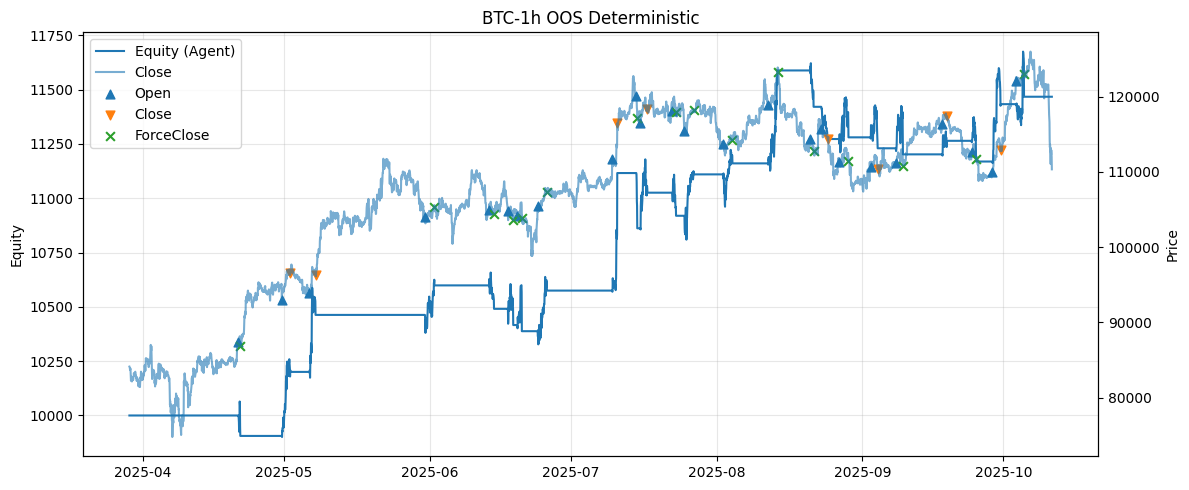

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_oos_eval(env, res, save_path: str | None = "oos_eval.png",
                  show_trades: bool = True, title: str | None = None):
    """
    Plottet Equity (links) und Close-Preis (rechts) über das OOS-Fenster.
    - env:   dein BitgetTradingEnv nach evaluate_agent_deterministic()
    - res:   dict von evaluate_agent_deterministic (enthält 'equity', 't_index')
    - save_path: PNG-Datei (oder None zum Nicht-Speichern)
    - show_trades: markiert Open/Close/Force-Close
    """
    equity = np.asarray(res["equity"], dtype=float)
    t_index = pd.DatetimeIndex(res["t_index"])
    closes = env.data_raw["Close"].loc[t_index]

    fig, ax1 = plt.subplots(figsize=(12, 5))
    # Equity-Kurve
    ax1.plot(t_index, equity, label="Equity (Agent)")
    ax1.set_ylabel("Equity")
    ax1.grid(True, alpha=0.3)

    # Preis (zweite Achse)
    ax2 = ax1.twinx()
    ax2.plot(t_index, closes.values, label="Close", alpha=0.6)
    ax2.set_ylabel("Price")

    # Titel & Legende
    if title is None:
        title = (f"Sharpe {res['sharpe']:.2f} | MDD {res['max_drawdown']:.2%} | "
                 f"NAV {res['nav_agent']:.2%} vs Mkt {res['nav_mkt']:.2%} | "
                 f"Exposure {res['exposure']:.1%}")
    ax1.set_title(title)

    # Trades markieren (optional)
    if show_trades and getattr(env, "trades", None):
        try:
            df_tr = pd.DataFrame(env.trades)
            df_tr = df_tr[df_tr["ts"].isin(t_index)]
            if not df_tr.empty:
                # einfache Marker: open/close/force_close
                opens = df_tr[df_tr["type"] == "open"]
                closes_tr = df_tr[df_tr["type"] == "close"]
                fcloses = df_tr[df_tr["type"] == "force_close"]

                # auf Preis-Achse markieren
                if not opens.empty:
                    ax2.scatter(opens["ts"], opens["price"], marker="^", s=40, label="Open")
                if not closes_tr.empty:
                    ax2.scatter(closes_tr["ts"], closes_tr["price"], marker="v", s=40, label="Close")
                if not fcloses.empty:
                    ax2.scatter(fcloses["ts"], fcloses["price"], marker="x", s=40, label="ForceClose")
        except Exception as e:
            print(f"⚠️ Trade-Markierung übersprungen: {e}")

    # kombinierte Legende
    l1, lab1 = ax1.get_legend_handles_labels()
    l2, lab2 = ax2.get_legend_handles_labels()
    ax1.legend(l1 + l2, lab1 + lab2, loc="upper left")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=120)
        print(f"🖼️ Plot gespeichert: {save_path}")
    plt.show()

plot_oos_eval(env_eval, res, save_path="ddqn_oos_eval.png",
              show_trades=True,
              title="BTC-1h OOS Deterministic")


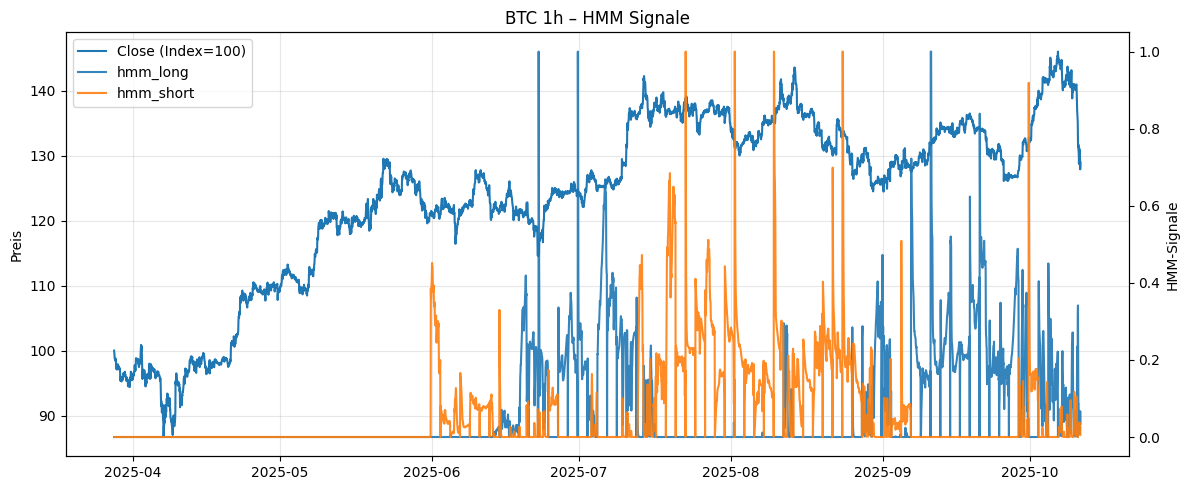

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Helfer: Spalten vereinheitlichen (wie im Env) ---------------------------
def _normalize_ohlcv(df: pd.DataFrame) -> pd.DataFrame:
    col_map = {
        'open':'Open','o':'Open',
        'high':'High','h':'High',
        'low':'Low','l':'Low',
        'close':'Close','c':'Close',
        'volume':'Volume','vol':'Volume','v':'Volume',
        'turnover':'Turnover','quote_volume':'Turnover','value':'Turnover'
    }
    new_cols = {c: col_map.get(str(c).strip().lower(), c) for c in df.columns}
    df = df.rename(columns=new_cols).copy()

    # Timestamp -> Index (falls vorhanden)
    if 'timestamp' in df.columns and not isinstance(df.index, pd.DatetimeIndex):
        df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True, errors='coerce')
        df = df.dropna(subset=['timestamp']).set_index('timestamp').sort_index()
    elif isinstance(df.index, pd.DatetimeIndex):
        df = df.sort_index()

    # Pflichtspalten prüfen
    required = ['Open','High','Low','Close']
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Fehlende OHLC-Spalten nach Normalisierung: {missing}")

    # Volume/Turnover optional ergänzen
    if 'Volume' not in df.columns:   df['Volume']   = 0.0
    if 'Turnover' not in df.columns: df['Turnover'] = df.get('Volume', 0.0)
    # numerisch casten
    for c in ['Open','High','Low','Close','Volume','Turnover']:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    return df.dropna(subset=['Open','High','Low','Close'])

# --- Plot-Funktion -----------------------------------------------------------
def plot_hmm_signals(df: pd.DataFrame, *,
                     use_features_already=True,
                     title="Close vs HMM signals",
                     start=None, end=None,
                     normalize_price=True):
    """
    use_features_already=False: df = Rohdaten (beliebige OHLCV-Benennungen)
    use_features_already=True:  df enthält bereits 'Close','hmm_long','hmm_short'
    """
    data = df.copy()
    if not use_features_already:
        data = _normalize_ohlcv(data)
        # add_indicators muss in deinem Scope definiert sein (aus deinem Projektcode)
        data = add_indicators(data)

    need = {"Close","hmm_long","hmm_short"}
    missing = need - set(data.columns)
    if missing:
        raise ValueError(f"Fehlende Spalten für den Plot: {missing}")

    if start is not None or end is not None:
        data = data.loc[start:end]

    price = data["Close"].astype(float)
    if normalize_price and len(price) > 0:
        price = 100.0 * price / float(price.iloc[0])

    hmm_long  = data["hmm_long"].astype(float)
    hmm_short = data["hmm_short"].astype(float)

    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.plot(price.index, price.values, label="Close (Index=100)" if normalize_price else "Close")
    ax1.set_ylabel("Preis"); ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.plot(hmm_long.index,  hmm_long.values,  label="hmm_long",  alpha=0.9)
    ax2.plot(hmm_short.index, hmm_short.values, label="hmm_short", alpha=0.9)
    ax2.set_ylabel("HMM-Signale")

    # gemeinsame Legende
    l1, lab1 = ax1.get_legend_handles_labels()
    l2, lab2 = ax2.get_legend_handles_labels()
    ax1.legend(l1 + l2, lab1 + lab2, loc="upper left")
    ax1.set_title(title)
    plt.tight_layout(); plt.show()

# --- Beispielaufrufe ---
# 1) Mit Rohdaten aus oos_streams:
df_raw = oos_streams[("BTC","1h")].copy()
plot_hmm_signals(df_raw, use_features_already=False, title="BTC 1h – HMM Signale", start="2023-01-01")

# 2) Wenn du bereits einen Feature-DF hast (z.B. env.features):
# plot_hmm_signals(env.features, use_features_already=True, title="BTC 1h – HMM Signale", start="2023-01-01")



In [2]:
python -c "import tensorflow as tf, google.protobuf as pb; print('TF', tf.__version__); import pkg_resources as pr; print('protobuf', pr.get_distribution('protobuf').version)"


SyntaxError: invalid syntax (3133256909.py, line 1)